### First Order Regressions
Run code to estimate the direct effects of the blockage

In [160]:
# Imports (Run before running anything else)
import matplotlib.pyplot as plt
import country_converter as cc
import shipping_network as sn
import statsmodels.api as sm
import geopandas as gpd
import pyfixest as pf
import seaborn as sns
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

#### Parameters
To make sure the code works for any canals, input the canal and a node on the canal here.
| Canal | Nodes In Canal |
| --- | --- |
| Suez Canal | `maritime2927` |
| Panama Canal | `maritime7249` |

In [161]:
canal_name = 'suez' 
orgin_node = 'maritime2927'
canal_file = 'data/Global port supply-chains/Maritime_transport/edges_suez_maritime.csv'

# canal_name = 'panama'
# orgin_node = 'maritime7249'
# canal_file = 'data/Global port supply-chains/Maritime_transport/edges_panama_maritime.csv'

ship_speed = 40 # km/h
tanker_speed = 20
cargo_speed = 40
reg_start = pd.Timestamp('2021-03-01', tz='UTC')
reg_end = pd.Timestamp('2021-04-5', tz='UTC')

# reg_start = pd.Timestamp('2019-03-04', tz='UTC')
# reg_end = pd.Timestamp('2019-04-08', tz='UTC')

save = True
present = False

PAGE_WIDTH = 7.5

if present:
    plt.style.use('metropolis')
    save_folder = 'presentation'
else:
    plt.style.use('default')
    plt.rcParams.update({
        "font.family": "serif",  # use serif/main font for text elements
        "text.usetex": True,     # use inline math for ticks
        "pgf.rcfonts": False     # don't setup fonts from rc parameters
        })
    save_folder = 'paper'

#### Port Level Impacts
Estimate the impacts of the canal blockage on a port based on their canal reliance

In [162]:
# read files
# Get file
port_imports = pd.read_csv('data/Daily_Port_Activity_Data_and_Trade_Estimates.csv')
ports = sn.geodataframe_from_csv('data/Global port supply-chains/Port_statistics/port_locations_value.csv')
ports = ports[['id', 'name', 'iso3', 'geometry', 'lat', 'lon']]
shipping_network = sn.geodataframe_from_csv('data/Global port supply-chains/Maritime_transport/maritime_network_flows.csv')
shipping_through_canal = sn.geodataframe_from_csv(canal_file)
edges = gpd.read_file('data/Global port supply-chains/Network/edges_maritime_corrected.gpkg')

# filter imports
port_imports = port_imports[port_imports['year'] == 2021] # filter year

# canal scores
shipping_network = sn.canal_reliance(shipping_network, shipping_through_canal, canal_name)

# port inflow scores
ports = ports.merge(
        right=shipping_network[['to_id', 'q_sea_flow', 'v_sea_flow', 'q_sea_flow_' + canal_name, 'v_sea_flow_' + canal_name, 'q_ratio_' + canal_name, 'v_ratio_' + canal_name]],
        left_on='id',
        right_on='to_id'
    )

# port distance from canal
ports = sn.fastest_route_from(orgin_node, edges, ports, canal_name)
ports['time_from_' + canal_name] = ports['dist_from_' + canal_name] // (ship_speed * 24)
ports['tanker_time_from_' + canal_name] = ports['dist_from_' + canal_name] // (tanker_speed * 24)
ports['cargo_time_from_' + canal_name] = ports['dist_from_' + canal_name] // (cargo_speed * 24)

# combine
total_port_imports = port_imports.merge( # port_id manually checked to work for 100 ports (thank god, this would be awful)
    right=ports,
    left_on='portid',
    right_on='id'
)

# logs
total_port_imports['log_import'] = np.log(total_port_imports['import']+1)
total_port_imports['log_import_tanker'] = np.log(total_port_imports['import_tanker']+1)
total_port_imports['log_import_cargo'] = np.log(total_port_imports['import_cargo']+1)

# normalize time
total_port_imports['ref_date'] = pd.to_datetime(total_port_imports['date']) - pd.to_timedelta(total_port_imports['time_from_' + canal_name], 'd')
total_port_imports['tanker_ref_date'] = pd.to_datetime(total_port_imports['date']) - pd.to_timedelta(total_port_imports['tanker_time_from_' + canal_name], 'd')
total_port_imports['cargo_ref_date'] = pd.to_datetime(total_port_imports['date']) - pd.to_timedelta(total_port_imports['cargo_time_from_' + canal_name], 'd')
total_port_imports['crash_now'] = total_port_imports['tanker_crash_now'] = total_port_imports['cargo_crash_now'] = 0
total_port_imports.loc[(total_port_imports['ref_date'] >= pd.Timestamp('2021-03-23', tz='UTC'))*
                    (total_port_imports['ref_date'] <= pd.Timestamp('2021-03-29', tz='UTC')), 'crash_now'] = 1
total_port_imports.loc[(total_port_imports['tanker_ref_date'] >= pd.Timestamp('2021-03-23', tz='UTC'))*
                    (total_port_imports['tanker_ref_date'] <= pd.Timestamp('2021-03-29', tz='UTC')), 'tanker_crash_now'] = 1
total_port_imports.loc[(total_port_imports['cargo_ref_date'] >= pd.Timestamp('2021-03-23', tz='UTC'))*
                    (total_port_imports['cargo_ref_date'] <= pd.Timestamp('2021-03-29', tz='UTC')), 'cargo_crash_now'] = 1
# total_port_imports.loc[(total_port_imports['ref_date'] >= pd.Timestamp('2019-03-26', tz='UTC'))*
#                     (total_port_imports['ref_date'] <= pd.Timestamp('2019-04-01', tz='UTC')), 'crash_now'] = 1
# total_port_imports.loc[(total_port_imports['tanker_ref_date'] >= pd.Timestamp('2019-03-26', tz='UTC'))*
#                     (total_port_imports['tanker_ref_date'] <= pd.Timestamp('2019-04-01', tz='UTC')), 'tanker_crash_now'] = 1
# total_port_imports.loc[(total_port_imports['cargo_ref_date'] >= pd.Timestamp('2019-03-26', tz='UTC'))*
#                     (total_port_imports['cargo_ref_date'] <= pd.Timestamp('2019-04-01', tz='UTC')), 'cargo_crash_now'] = 1

total_port_imports[f'log_v_ratio_{canal_name}'] = np.log(1 - total_port_imports[f'v_ratio_{canal_name}'])

# Regression
res_dummy = pf.feols(
    f'log_import ~  crash_now:v_ratio_{canal_name} + crash_now | portid',
    data=total_port_imports[(total_port_imports['ref_date'] >= reg_start)*(total_port_imports['ref_date'] <= reg_end)]
)
res_no_dummy = pf.feols(
    f'log_import ~  crash_now:v_ratio_{canal_name} | portid',
    data=total_port_imports[(total_port_imports['ref_date'] >= reg_start)*(total_port_imports['ref_date'] <= reg_end)]
)
res_tanker_dummy = pf.feols(
    f'log_import_tanker ~  tanker_crash_now:v_ratio_{canal_name} + tanker_crash_now | portid',
    data=total_port_imports[(total_port_imports['tanker_ref_date'] >= reg_start)*(total_port_imports['tanker_ref_date'] <= reg_end)]
)
res_tanker_no_dummy = pf.feols(
    f'log_import_tanker ~  tanker_crash_now:v_ratio_{canal_name} | portid',
    data=total_port_imports[(total_port_imports['tanker_ref_date'] >= reg_start)*(total_port_imports['tanker_ref_date'] <= reg_end)]
)
res_cargo_dummy = pf.feols(
    f'log_import_cargo ~  cargo_crash_now:v_ratio_{canal_name} + cargo_crash_now | portid',
    data=total_port_imports[(total_port_imports['cargo_ref_date'] >= reg_start)*(total_port_imports['cargo_ref_date'] <= reg_end)]
)
res_cargo_no_dummy = pf.feols(
    f'log_import_cargo ~  cargo_crash_now:v_ratio_{canal_name} | portid',
    data=total_port_imports[(total_port_imports['cargo_ref_date'] >= reg_start)*(total_port_imports['cargo_ref_date'] <= reg_end)]
)
res_dummy.summary()
res_no_dummy.summary()
res_tanker_dummy.summary()
res_tanker_no_dummy.summary()
res_cargo_dummy.summary()
res_cargo_no_dummy.summary()

/Users/gavinengelstad/Documents/Documents - Gavin’s MacBook Pro/School/Spring '24/International Trade/Capstone/final/code/shipping_network.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shipping_network_through_canal.rename(
/Users/gavinengelstad/Documents/Documents - Gavin’s MacBook Pro/School/Spring '24/International Trade/Capstone/final/code/shipping_network.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ports['dist_from_' + canal_name][i] = distance # add results to dictionary
/Users/gavinengelstad/Documents/Documents - Gavin’s MacBook Pro/School/Spring '24/International Trade/Capstone/final/code/shipp

###

Estimation:  OLS
Dep. var.: log_import, Fixed effects: portid
Inference:  CRV1
Observations:  48744

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| crash_now              |      0.045 |        0.036 |     1.245 |      0.213 | -0.026 |   0.117 |
| crash_now:v_ratio_suez |     -1.171 |        0.448 |    -2.613 |      0.009 | -2.050 |  -0.292 |
---
RMSE: 3.098   R2: 0.519   R2 Within: 0.0
###

Estimation:  OLS
Dep. var.: log_import, Fixed effects: portid
Inference:  CRV1
Observations:  48744

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| crash_now:v_ratio_suez |     -0.999 |        0.426 |    -2.343 |      0.019 | -1.836 |  -0.163 |
---
RMSE: 3.098   R2: 0.519   R2 Within: 0.0
###



<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
/var/folders/7l/ffzd6jqd4k1g060d9whf4v2c0000gn/T/ipykernel_44334/477213177.py:8: SyntaxWarning: invalid escape sequence '\%'
  ax[1, 0].set_ylabel('\% Change in Imports Durring Blockage')
/opt/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/7l/ffzd6jqd4k1g060d9whf4v2c0000gn/T/ipykernel_44334/477213177.py:23: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot( # desity of effect
/opt/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf valu

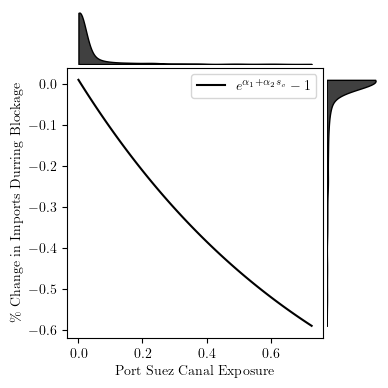

In [163]:
fig, ax = plt.subplots(2, 2, width_ratios=[5, 1], height_ratios=[1, 5], sharex='col', sharey='row')
fig.set_figwidth(PAGE_WIDTH / 2)
fig.set_figheight(PAGE_WIDTH / 2)
ax[0, 0].axis('off') # top left corner (exposure density)
ax[0, 1].axis('off') # top right corner (blank)
ax[1, 1].axis('off') # top right corner (effect density)
ax[1, 0].set_xlabel(f'Port {canal_name.title()} Canal Exposure')
ax[1, 0].set_ylabel('\% Change in Imports Durring Blockage')

x = np.linspace(min(ports['v_ratio_'+canal_name]), max(ports['v_ratio_'+canal_name]), 100)
y = np.exp(res_cargo_dummy.coef()['cargo_crash_now'] + x*res_cargo_dummy.coef()['cargo_crash_now:v_ratio_'+canal_name])-1

ax[1, 0].plot(x, y, 'k', label=r'$e^{\alpha_1 + \alpha_2 s_c}-1$') # plot the data

sns.kdeplot( # desity of exposure
    ports['v_ratio_suez'],
    ax=ax[0, 0],
    cut=0,
    color='k',
    multiple="stack"
)

sns.kdeplot( # desity of effect
    np.exp(res_cargo_dummy.coef()['cargo_crash_now'] + ports['v_ratio_suez']*res_cargo_dummy.coef()['cargo_crash_now:v_ratio_suez'])-1,
    ax=ax[1, 1],
    vertical=True,
    cut=0,
    color='k',
    multiple="stack"
)

ax[1, 0].legend()
fig.tight_layout(pad=0.25)
if save: fig.savefig(f'../{save_folder}/graphs/port_{canal_name}_exposure_effect.pdf')

#### Robustness: Port Quantity Regression

/Users/gavinengelstad/Documents/Documents - Gavin’s MacBook Pro/School/Spring '24/International Trade/Capstone/final/code/shipping_network.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shipping_network_through_canal.rename(
/Users/gavinengelstad/Documents/Documents - Gavin’s MacBook Pro/School/Spring '24/International Trade/Capstone/final/code/shipping_network.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ports['dist_from_' + canal_name][i] = distance # add results to dictionary
/Users/gavinengelstad/Documents/Documents - Gavin’s MacBook Pro/School/Spring '24/International Trade/Capstone/final/code/shipp

###

Estimation:  OLS
Dep. var.: log_import, Fixed effects: portid
Inference:  CRV1
Observations:  48744

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| crash_now              |      0.048 |        0.036 |     1.342 |      0.180 | -0.022 |   0.119 |
| crash_now:q_ratio_suez |     -1.655 |        0.508 |    -3.254 |      0.001 | -2.652 |  -0.657 |
---
RMSE: 3.098   R2: 0.519   R2 Within: 0.0
###

Estimation:  OLS
Dep. var.: log_import, Fixed effects: portid
Inference:  CRV1
Observations:  48744

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| crash_now:q_ratio_suez |     -1.467 |        0.494 |    -2.970 |      0.003 | -2.437 |  -0.498 |
---
RMSE: 3.098   R2: 0.519   R2 Within: 0.0
###



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           q_ratio_suez   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     3724.
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        11:16:59   Log-Likelihood:                 2483.6
No. Observations:                1358   AIC:                            -4963.
Df Residuals:                    1356   BIC:                            -4953.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0004      0.001      0.348      0.728      -0.002       0.003
v_ratio_suez     0.7485      0.012     61.022      0.000       0.724       0.773
==============================================================================
Omnibus:                      684.095   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            69406.792
Skew:                           1.382   Prob(JB):                         0.00
Kurtosis:                      37.914   Cond. No.                         11.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

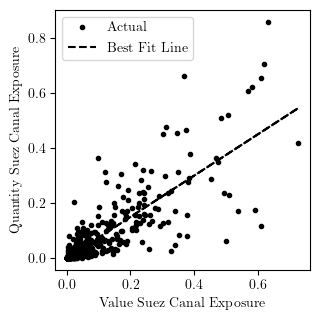

In [164]:
# read files
# Get file
port_imports = pd.read_csv('data/Daily_Port_Activity_Data_and_Trade_Estimates.csv')
ports = sn.geodataframe_from_csv('data/Global port supply-chains/Port_statistics/port_locations_value.csv')
ports = ports[['id', 'name', 'iso3', 'geometry', 'lat', 'lon']]
shipping_network = sn.geodataframe_from_csv('data/Global port supply-chains/Maritime_transport/maritime_network_flows.csv')
shipping_through_canal = sn.geodataframe_from_csv(canal_file)
edges = gpd.read_file('data/Global port supply-chains/Network/edges_maritime_corrected.gpkg')

# filter imports
port_imports = port_imports[port_imports['year'] == 2021] # filter year

# canal scores
shipping_network = sn.canal_reliance(shipping_network, shipping_through_canal, canal_name)

# port inflow scores
ports = ports.merge(
        right=shipping_network[['to_id', 'q_sea_flow', 'v_sea_flow', 'q_sea_flow_' + canal_name, 'v_sea_flow_' + canal_name, 'q_ratio_' + canal_name, 'v_ratio_' + canal_name]],
        left_on='id',
        right_on='to_id'
    )

# port distance from canal
ports = sn.fastest_route_from(orgin_node, edges, ports, canal_name)
ports['time_from_' + canal_name] = ports['dist_from_' + canal_name] // (ship_speed * 24)
ports['tanker_time_from_' + canal_name] = ports['dist_from_' + canal_name] // (tanker_speed * 24)
ports['cargo_time_from_' + canal_name] = ports['dist_from_' + canal_name] // (cargo_speed * 24)

# combine
total_port_imports = port_imports.merge( # port_id manually checked to work for 100 ports (thank god, this would be awful)
    right=ports,
    left_on='portid',
    right_on='id'
)

# logs
total_port_imports['log_import'] = np.log(total_port_imports['import']+1)
total_port_imports['log_import_tanker'] = np.log(total_port_imports['import_tanker']+1)
total_port_imports['log_import_cargo'] = np.log(total_port_imports['import_cargo']+1)

# normalize time
total_port_imports['ref_date'] = pd.to_datetime(total_port_imports['date']) - pd.to_timedelta(total_port_imports['time_from_' + canal_name], 'd')
total_port_imports['tanker_ref_date'] = pd.to_datetime(total_port_imports['date']) - pd.to_timedelta(total_port_imports['tanker_time_from_' + canal_name], 'd')
total_port_imports['cargo_ref_date'] = pd.to_datetime(total_port_imports['date']) - pd.to_timedelta(total_port_imports['cargo_time_from_' + canal_name], 'd')
total_port_imports['crash_now'] = total_port_imports['tanker_crash_now'] = total_port_imports['cargo_crash_now'] = 0
total_port_imports.loc[(total_port_imports['ref_date'] >= pd.Timestamp('2021-03-23', tz='UTC'))*
                    (total_port_imports['ref_date'] <= pd.Timestamp('2021-03-29', tz='UTC')), 'crash_now'] = 1
total_port_imports.loc[(total_port_imports['tanker_ref_date'] >= pd.Timestamp('2021-03-23', tz='UTC'))*
                    (total_port_imports['tanker_ref_date'] <= pd.Timestamp('2021-03-29', tz='UTC')), 'tanker_crash_now'] = 1
total_port_imports.loc[(total_port_imports['cargo_ref_date'] >= pd.Timestamp('2021-03-23', tz='UTC'))*
                    (total_port_imports['cargo_ref_date'] <= pd.Timestamp('2021-03-29', tz='UTC')), 'cargo_crash_now'] = 1

# Regression
res_dummy = pf.feols(
    f'log_import ~  crash_now:q_ratio_{canal_name} + crash_now | portid',
    data=total_port_imports[(total_port_imports['ref_date'] >= reg_start)*(total_port_imports['ref_date'] <= reg_end)]
)
res_no_dummy = pf.feols(
    f'log_import ~  crash_now:q_ratio_{canal_name} | portid',
    data=total_port_imports[(total_port_imports['ref_date'] >= reg_start)*(total_port_imports['ref_date'] <= reg_end)]
)
res_tanker_dummy = pf.feols(
    f'log_import_tanker ~  tanker_crash_now:q_ratio_{canal_name} + tanker_crash_now | portid',
    data=total_port_imports[(total_port_imports['tanker_ref_date'] >= reg_start)*(total_port_imports['tanker_ref_date'] <= reg_end)]
)
res_tanker_no_dummy = pf.feols(
    f'log_import_tanker ~  tanker_crash_now:q_ratio_{canal_name} | portid',
    data=total_port_imports[(total_port_imports['tanker_ref_date'] >= reg_start)*(total_port_imports['tanker_ref_date'] <= reg_end)]
)
res_cargo_dummy = pf.feols(
    f'log_import_cargo ~  cargo_crash_now:q_ratio_{canal_name} + cargo_crash_now | portid',
    data=total_port_imports[(total_port_imports['cargo_ref_date'] >= reg_start)*(total_port_imports['cargo_ref_date'] <= reg_end)]
)
res_cargo_no_dummy = pf.feols(
    f'log_import_cargo ~  cargo_crash_now:q_ratio_{canal_name} | portid',
    data=total_port_imports[(total_port_imports['cargo_ref_date'] >= reg_start)*(total_port_imports['cargo_ref_date'] <= reg_end)]
)
res_dummy.summary()
res_no_dummy.summary()
res_tanker_dummy.summary()
res_tanker_no_dummy.summary()
res_cargo_dummy.summary()
res_cargo_no_dummy.summary()

# value vs quanitty
reg = sm.OLS(ports['q_ratio_' + canal_name], sm.add_constant(ports['v_ratio_' + canal_name])).fit()

fig, ax = plt.subplots()
fig.set_figheight(3)
fig.set_figwidth(3)
ax.set_ylabel('Quantity ' + canal_name.title() + ' Canal Exposure')
ax.set_xlabel('Value ' + canal_name.title() + ' Canal Exposure')

ax.plot(ports['v_ratio_' + canal_name], ports['q_ratio_' + canal_name], 'k.', label='Actual')
ax.plot(ports['v_ratio_' + canal_name], reg.predict(), 'k--', label='Best Fit Line')

ax.legend()
fig.tight_layout(pad=0)
if save: fig.savefig(f'../{save_folder}/graphs/port_v_vs_q_exposure_{canal_name}.pdf')
reg.summary()

#### Robustness: Dynamic Model

/Users/gavinengelstad/Documents/Documents - Gavin’s MacBook Pro/School/Spring '24/International Trade/Capstone/final/code/shipping_network.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shipping_network_through_canal.rename(
/Users/gavinengelstad/Documents/Documents - Gavin’s MacBook Pro/School/Spring '24/International Trade/Capstone/final/code/shipping_network.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ports['dist_from_' + canal_name][i] = distance # add results to dictionary
/Users/gavinengelstad/Documents/Documents - Gavin’s MacBook Pro/School/Spring '24/International Trade/Capstone/final/code/shipp

###

Estimation:  OLS
Dep. var.: log_import, Fixed effects: portid
Inference:  CRV1
Observations:  48744

| Coefficient                                |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-------------------------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| C(time_since_blockage)[T.-22]:v_ratio_suez |      0.409 |        1.307 |     0.313 |      0.754 | -2.155 |   2.973 |
| C(time_since_blockage)[T.-21]:v_ratio_suez |     -0.447 |        1.322 |    -0.338 |      0.735 | -3.041 |   2.147 |
| C(time_since_blockage)[T.-20]:v_ratio_suez |      1.985 |        1.517 |     1.308 |      0.191 | -0.992 |   4.962 |
| C(time_since_blockage)[T.-19]:v_ratio_suez |     -1.124 |        1.199 |    -0.938 |      0.349 | -3.477 |   1.228 |
| C(time_since_blockage)[T.-18]:v_ratio_suez |     -0.145 |        1.265 |    -0.115 |      0.909 | -2.626 |   2.336 |
| C(time_since_blockage)[T.-17]:v_ratio_suez |      0.393 |  

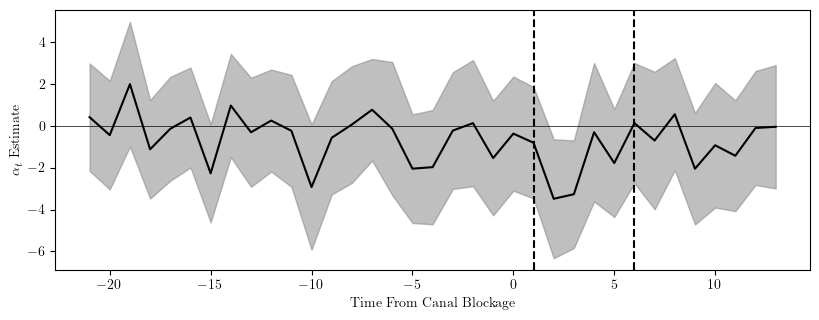

In [165]:
# read files
# Get file
port_imports = pd.read_csv('data/Daily_Port_Activity_Data_and_Trade_Estimates.csv')
ports = sn.geodataframe_from_csv('data/Global port supply-chains/Port_statistics/port_locations_value.csv')
ports = ports[['id', 'name', 'iso3', 'geometry', 'lat', 'lon']]
shipping_network = sn.geodataframe_from_csv('data/Global port supply-chains/Maritime_transport/maritime_network_flows.csv')
shipping_through_canal = sn.geodataframe_from_csv(canal_file)
edges = gpd.read_file('data/Global port supply-chains/Network/edges_maritime_corrected.gpkg')

# filter imports
port_imports = port_imports[port_imports['year'] == 2021] # filter year

# canal scores
shipping_network = sn.canal_reliance(shipping_network, shipping_through_canal, canal_name)

# port inflow scores
ports = ports.merge(
        right=shipping_network[['to_id', 'q_sea_flow', 'v_sea_flow', 'q_sea_flow_' + canal_name, 'v_sea_flow_' + canal_name, 'q_ratio_' + canal_name, 'v_ratio_' + canal_name]],
        left_on='id',
        right_on='to_id'
    )

# port distance from canal
ports = sn.fastest_route_from(orgin_node, edges, ports, canal_name)
ports['time_from_' + canal_name] = ports['dist_from_' + canal_name] // (ship_speed * 24)
ports['tanker_time_from_' + canal_name] = ports['dist_from_' + canal_name] // (tanker_speed * 24)
ports['cargo_time_from_' + canal_name] = ports['dist_from_' + canal_name] // (cargo_speed * 24)

# combine
total_port_imports = port_imports.merge( # port_id manually checked to work for 100 ports (thank god, this would be awful)
    right=ports,
    left_on='portid',
    right_on='id'
)

# logs
total_port_imports['log_import'] = np.log(total_port_imports['import']+1)

# normalize time
total_port_imports['ref_date'] = pd.to_datetime(total_port_imports['date']) - pd.to_timedelta(total_port_imports['time_from_' + canal_name], 'd')
total_port_imports['time_since_blockage'] = (total_port_imports['ref_date'] - pd.Timestamp('2021-03-23', tz='UTC')).dt.days

# Regression
res_no_dummy = pf.feols(
    f'log_import ~  C(time_since_blockage):v_ratio_{canal_name} | portid',
    data=total_port_imports[(total_port_imports['ref_date'] >= reg_start)*(total_port_imports['ref_date'] <= reg_end)]
)
res_dummy = pf.feols(
    f'log_import ~  C(time_since_blockage):v_ratio_{canal_name} + C(time_since_blockage) | portid',
    data=total_port_imports[(total_port_imports['ref_date'] >= reg_start)*(total_port_imports['ref_date'] <= reg_end)]
)
res_no_dummy.summary()
res_dummy.summary()

# setup plot
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(3)
ax.set_xlabel("Time From Canal Blockage")
ax.set_ylabel(r"$\alpha_t$ Estimate")

# plot coefficeints
ax.axvline(1, color='k', linestyle='--')
ax.axvline(6, color='k', linestyle='--')
ax.axhline(0, color='k', linestyle='-', linewidth=0.5)

times = range(-21, 14)
ax.plot(times, res_no_dummy.coef(), 'k-')
ax.fill_between(times,
            res_no_dummy.confint()['0.025%'],
           res_no_dummy.confint()['0.975%'],
           color='gray', alpha=0.5)

# final things
fig.tight_layout(pad=0)
if save: fig.savefig(f'../{save_folder}/graphs/port_{canal_name}_dynamic_reg.pdf')

#### Robustness: Speed Choice

/Users/gavinengelstad/Documents/Documents - Gavin’s MacBook Pro/School/Spring '24/International Trade/Capstone/final/code/shipping_network.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shipping_network_through_canal.rename(
/Users/gavinengelstad/Documents/Documents - Gavin’s MacBook Pro/School/Spring '24/International Trade/Capstone/final/code/shipping_network.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ports['dist_from_' + canal_name][i] = distance # add results to dictionary
/Users/gavinengelstad/Documents/Documents - Gavin’s MacBook Pro/School/Spring '24/International Trade/Capstone/final/code/shipp

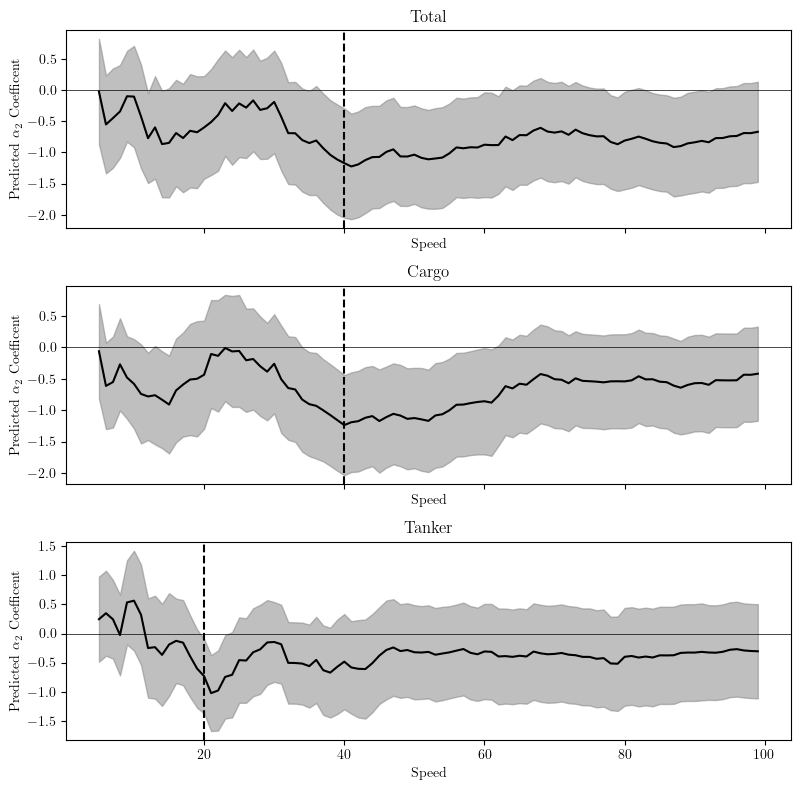

In [175]:
# read files
# Get file
port_imports = pd.read_csv('data/Daily_Port_Activity_Data_and_Trade_Estimates.csv')
ports = sn.geodataframe_from_csv('data/Global port supply-chains/Port_statistics/port_locations_value.csv')
ports = ports[['id', 'name', 'iso3', 'geometry', 'lat', 'lon']]
shipping_network = sn.geodataframe_from_csv('data/Global port supply-chains/Maritime_transport/maritime_network_flows.csv')
shipping_through_canal = sn.geodataframe_from_csv(canal_file)
edges = gpd.read_file('data/Global port supply-chains/Network/edges_maritime_corrected.gpkg')

# filter imports
port_imports = port_imports[port_imports['year'] == 2021] # filter year

# canal scores
shipping_network = sn.canal_reliance(shipping_network, shipping_through_canal, canal_name)

# port inflow scores
ports = ports.merge(
        right=shipping_network[['to_id', 'q_sea_flow', 'v_sea_flow', 'q_sea_flow_' + canal_name, 'v_sea_flow_' + canal_name, 'q_ratio_' + canal_name, 'v_ratio_' + canal_name]],
        left_on='id',
        right_on='to_id'
    )
ports = sn.fastest_route_from(orgin_node, edges, ports, canal_name)

# track reg results
dummy = []
no_dummy = []
tanker_dummy = []
tanker_no_dummy = []
cargo_dummy = []
cargo_no_dummy = []

speeds = range(5, 100)
for speed in speeds:
    # port distance from canal
    ports['time_from_' + canal_name] = ports['dist_from_' + canal_name] // (speed * 24)
    ports['tanker_time_from_' + canal_name] = ports['dist_from_' + canal_name] // (speed * 24)
    ports['cargo_time_from_' + canal_name] = ports['dist_from_' + canal_name] // (speed * 24)

    # combine
    total_port_imports = port_imports.merge( # port_id manually checked to work for 100 ports (thank god, this would be awful)
        right=ports,
        left_on='portid',
        right_on='id'
    )

    # logs
    total_port_imports['log_import'] = np.log(total_port_imports['import']+1)
    total_port_imports['log_import_tanker'] = np.log(total_port_imports['import_tanker']+1)
    total_port_imports['log_import_cargo'] = np.log(total_port_imports['import_cargo']+1)

    # normalize time
    total_port_imports['ref_date'] = pd.to_datetime(total_port_imports['date']) - pd.to_timedelta(total_port_imports['time_from_' + canal_name], 'd')
    total_port_imports['tanker_ref_date'] = pd.to_datetime(total_port_imports['date']) - pd.to_timedelta(total_port_imports['tanker_time_from_' + canal_name], 'd')
    total_port_imports['cargo_ref_date'] = pd.to_datetime(total_port_imports['date']) - pd.to_timedelta(total_port_imports['cargo_time_from_' + canal_name], 'd')
    total_port_imports['crash_now'] = total_port_imports['tanker_crash_now'] = total_port_imports['cargo_crash_now'] = 0
    total_port_imports.loc[(total_port_imports['ref_date'] >= pd.Timestamp('2021-03-23', tz='UTC'))*
                        (total_port_imports['ref_date'] <= pd.Timestamp('2021-03-29', tz='UTC')), 'crash_now'] = 1
    total_port_imports.loc[(total_port_imports['tanker_ref_date'] >= pd.Timestamp('2021-03-23', tz='UTC'))*
                        (total_port_imports['tanker_ref_date'] <= pd.Timestamp('2021-03-29', tz='UTC')), 'tanker_crash_now'] = 1
    total_port_imports.loc[(total_port_imports['cargo_ref_date'] >= pd.Timestamp('2021-03-23', tz='UTC'))*
                        (total_port_imports['cargo_ref_date'] <= pd.Timestamp('2021-03-29', tz='UTC')), 'cargo_crash_now'] = 1

    # Regression
    res_dummy = pf.feols(
        f'log_import ~  crash_now:v_ratio_{canal_name} + crash_now | portid',
        data=total_port_imports[(total_port_imports['ref_date'] >= reg_start)*(total_port_imports['ref_date'] <= reg_end)]
    )
    res_no_dummy = pf.feols(
        f'log_import ~  crash_now:v_ratio_{canal_name} | portid',
        data=total_port_imports[(total_port_imports['ref_date'] >= reg_start)*(total_port_imports['ref_date'] <= reg_end)]
    )
    res_tanker_dummy = pf.feols(
        f'log_import_tanker ~  tanker_crash_now:v_ratio_{canal_name} + tanker_crash_now | portid',
        data=total_port_imports[(total_port_imports['tanker_ref_date'] >= reg_start)*(total_port_imports['tanker_ref_date'] <= reg_end)]
    )
    res_tanker_no_dummy = pf.feols(
        f'log_import_tanker ~  tanker_crash_now:v_ratio_{canal_name} | portid',
        data=total_port_imports[(total_port_imports['tanker_ref_date'] >= reg_start)*(total_port_imports['tanker_ref_date'] <= reg_end)]
    )
    res_cargo_dummy = pf.feols(
        f'log_import_cargo ~  cargo_crash_now:v_ratio_{canal_name} + cargo_crash_now | portid',
        data=total_port_imports[(total_port_imports['cargo_ref_date'] >= reg_start)*(total_port_imports['cargo_ref_date'] <= reg_end)]
    )
    res_cargo_no_dummy = pf.feols(
        f'log_import_cargo ~  cargo_crash_now:v_ratio_{canal_name} | portid',
        data=total_port_imports[(total_port_imports['cargo_ref_date'] >= reg_start)*(total_port_imports['cargo_ref_date'] <= reg_end)]
    )
    dummy.append(res_dummy)
    no_dummy.append(res_no_dummy)
    tanker_dummy.append(res_tanker_dummy)
    tanker_no_dummy.append(res_tanker_no_dummy)
    cargo_dummy.append(res_cargo_dummy)
    cargo_no_dummy.append(res_cargo_no_dummy)

# setup plot
if present:
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()
    ax = [ax1, ax2, ax3]
    fig = [fig1, fig2, fig3]

    for f in fig:
        f.set_figwidth(8)
        f.set_figheight(3)
else:
    fig, ax = plt.subplots(3, sharex=True)
    fig.set_figwidth(8)
    fig.set_figheight(8)


ax[0].set_title('Total')
ax[1].set_title('Cargo')
ax[2].set_title('Tanker')
for i in range(3):
    ax[i].set_xlabel("Speed")
    ax[i].set_ylabel(r"Predicted $\alpha_2$ Coefficent")
    ax[i].axhline(0, color='k', linestyle='-', linewidth=0.5)

# plot overall coefficeints
ax[0].plot(speeds, [d.coef()['crash_now:v_ratio_' + canal_name] for d in dummy], 'k-')
ax[0].fill_between(speeds,
           [d.confint()['0.025%']['crash_now:v_ratio_' + canal_name] for d in dummy],
           [d.confint()['0.975%']['crash_now:v_ratio_' + canal_name] for d in dummy],
           color='gray', alpha=0.5)
ax[0].axvline(40, color='k', linestyle='--')

# plot cargo coefficeints
ax[1].plot(speeds, [d.coef()['cargo_crash_now:v_ratio_' + canal_name] for d in cargo_dummy], 'k-')
ax[1].fill_between(speeds,
           [d.confint()['0.025%']['cargo_crash_now:v_ratio_' + canal_name] for d in cargo_dummy],
           [d.confint()['0.975%']['cargo_crash_now:v_ratio_' + canal_name] for d in cargo_dummy],
           color='gray', alpha=0.5)
ax[1].axvline(40, color='k', linestyle='--')

# plot tanker coefficeints
ax[2].plot(speeds, [d.coef()['tanker_crash_now:v_ratio_' + canal_name] for d in tanker_dummy], 'k-')
ax[2].fill_between(speeds,
           [d.confint()['0.025%']['tanker_crash_now:v_ratio_' + canal_name] for d in tanker_dummy],
           [d.confint()['0.975%']['tanker_crash_now:v_ratio_' + canal_name] for d in tanker_dummy],
           color='gray', alpha=0.5)
ax[2].axvline(20, color='k', linestyle='--')

# final things
if present:
    for f in fig:
        f.tight_layout(pad=0)


    if save:
        fig1.savefig(f'../{save_folder}/graphs/speed_port_' + canal_name +'_reg_est.pdf')
        fig2.savefig(f'../{save_folder}/graphs/speed_port_' + canal_name +'_reg_est_cargo.pdf')
        fig3.savefig(f'../{save_folder}/graphs/speed_port_' + canal_name +'_reg_est_tanker.pdf')

else:
    fig.tight_layout()
    if save: fig.savefig(f'../{save_folder}/graphs/speed_port_' + canal_name +'_reg_est.pdf')

#### Robustness: Time Effects

In [167]:
# read files
# Get file
port_imports = pd.read_csv('data/Daily_Port_Activity_Data_and_Trade_Estimates.csv')
ports = sn.geodataframe_from_csv('data/Global port supply-chains/Port_statistics/port_locations_value.csv')
ports = ports[['id', 'name', 'iso3', 'geometry', 'lat', 'lon']]
shipping_network = sn.geodataframe_from_csv('data/Global port supply-chains/Maritime_transport/maritime_network_flows.csv')
shipping_through_canal = sn.geodataframe_from_csv(canal_file)
edges = gpd.read_file('data/Global port supply-chains/Network/edges_maritime_corrected.gpkg')

# filter imports
port_imports = port_imports[port_imports['year'] == 2021] # filter year

# canal scores
shipping_network = sn.canal_reliance(shipping_network, shipping_through_canal, canal_name)

# port inflow scores
ports = ports.merge(
        right=shipping_network[['to_id', 'q_sea_flow', 'v_sea_flow', 'q_sea_flow_' + canal_name, 'v_sea_flow_' + canal_name, 'q_ratio_' + canal_name, 'v_ratio_' + canal_name]],
        left_on='id',
        right_on='to_id'
    )

# port distance from canal
ports = sn.fastest_route_from(orgin_node, edges, ports, canal_name)
ports['time_from_' + canal_name] = ports['dist_from_' + canal_name] // (ship_speed * 24)
ports['tanker_time_from_' + canal_name] = ports['dist_from_' + canal_name] // (tanker_speed * 24)
ports['cargo_time_from_' + canal_name] = ports['dist_from_' + canal_name] // (cargo_speed * 24)

# combine
total_port_imports = port_imports.merge( # port_id manually checked to work for 100 ports (thank god, this would be awful)
    right=ports,
    left_on='portid',
    right_on='id'
)

# logs
total_port_imports['log_import'] = np.log(total_port_imports['import']+1)
total_port_imports['log_import_tanker'] = np.log(total_port_imports['import_tanker']+1)
total_port_imports['log_import_cargo'] = np.log(total_port_imports['import_cargo']+1)

# normalize time
total_port_imports['ref_date'] = pd.to_datetime(total_port_imports['date']) - pd.to_timedelta(total_port_imports['time_from_' + canal_name], 'd')
total_port_imports['tanker_ref_date'] = pd.to_datetime(total_port_imports['date']) - pd.to_timedelta(total_port_imports['tanker_time_from_' + canal_name], 'd')
total_port_imports['cargo_ref_date'] = pd.to_datetime(total_port_imports['date']) - pd.to_timedelta(total_port_imports['cargo_time_from_' + canal_name], 'd')
total_port_imports['crash_now'] = total_port_imports['tanker_crash_now'] = total_port_imports['cargo_crash_now'] = 0
total_port_imports.loc[(total_port_imports['ref_date'] >= pd.Timestamp('2021-03-23', tz='UTC'))*
                    (total_port_imports['ref_date'] <= pd.Timestamp('2021-03-29', tz='UTC')), 'crash_now'] = 1
total_port_imports.loc[(total_port_imports['tanker_ref_date'] >= pd.Timestamp('2021-03-23', tz='UTC'))*
                    (total_port_imports['tanker_ref_date'] <= pd.Timestamp('2021-03-29', tz='UTC')), 'tanker_crash_now'] = 1
total_port_imports.loc[(total_port_imports['cargo_ref_date'] >= pd.Timestamp('2021-03-23', tz='UTC'))*
                    (total_port_imports['cargo_ref_date'] <= pd.Timestamp('2021-03-29', tz='UTC')), 'cargo_crash_now'] = 1

# Regression
res_date = pf.feols(
    f'log_import ~  crash_now:v_ratio_{canal_name} | portid + date',
    data=total_port_imports[(total_port_imports['ref_date'] >= reg_start)*(total_port_imports['ref_date'] <= reg_end)]
)
res_ref_date = pf.feols(
    f'log_import ~  crash_now:v_ratio_{canal_name} | portid + ref_date',
    data=total_port_imports[(total_port_imports['ref_date'] >= reg_start)*(total_port_imports['ref_date'] <= reg_end)]
)
res_date_ref_date = pf.feols(
    f'log_import ~  crash_now:v_ratio_{canal_name} | portid + date + ref_date',
    data=total_port_imports[(total_port_imports['ref_date'] >= reg_start)*(total_port_imports['ref_date'] <= reg_end)]
)
res_date.summary()
res_ref_date.summary()
res_date_ref_date.summary()

/Users/gavinengelstad/Documents/Documents - Gavin’s MacBook Pro/School/Spring '24/International Trade/Capstone/final/code/shipping_network.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shipping_network_through_canal.rename(
/Users/gavinengelstad/Documents/Documents - Gavin’s MacBook Pro/School/Spring '24/International Trade/Capstone/final/code/shipping_network.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ports['dist_from_' + canal_name][i] = distance # add results to dictionary
/Users/gavinengelstad/Documents/Documents - Gavin’s MacBook Pro/School/Spring '24/International Trade/Capstone/final/code/shipp

###

Estimation:  OLS
Dep. var.: log_import, Fixed effects: portid+date
Inference:  CRV1
Observations:  48744

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| crash_now:v_ratio_suez |     -0.921 |        0.435 |    -2.118 |      0.034 | -1.774 |  -0.068 |
---
RMSE: 3.094   R2: 0.52   R2 Within: 0.0
###

Estimation:  OLS
Dep. var.: log_import, Fixed effects: portid+ref_date
Inference:  CRV1
Observations:  48744

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| crash_now:v_ratio_suez |     -1.171 |        0.448 |    -2.613 |      0.009 | -2.050 |  -0.292 |
---
RMSE: 3.097   R2: 0.519   R2 Within: 0.0
###

Estimation:  OLS
Dep. var.: log_import, Fixed effects: portid+date+ref_date
Inference:

#### Robustness: Regression Bands

In [168]:
# read files
# Get file
port_imports = pd.read_csv('data/Daily_Port_Activity_Data_and_Trade_Estimates.csv')
ports = sn.geodataframe_from_csv('data/Global port supply-chains/Port_statistics/port_locations_value.csv')
ports = ports[['id', 'name', 'iso3', 'geometry', 'lat', 'lon']]
shipping_network = sn.geodataframe_from_csv('data/Global port supply-chains/Maritime_transport/maritime_network_flows.csv')
shipping_through_canal = sn.geodataframe_from_csv(canal_file)
edges = gpd.read_file('data/Global port supply-chains/Network/edges_maritime_corrected.gpkg')

# filter imports
port_imports = port_imports[port_imports['year'] == 2021] # filter year

# canal scores
shipping_network = sn.canal_reliance(shipping_network, shipping_through_canal, canal_name)

# port inflow scores
ports = ports.merge(
        right=shipping_network[['to_id', 'q_sea_flow', 'v_sea_flow', 'q_sea_flow_' + canal_name, 'v_sea_flow_' + canal_name, 'q_ratio_' + canal_name, 'v_ratio_' + canal_name]],
        left_on='id',
        right_on='to_id'
    )

# port distance from canal
ports = sn.fastest_route_from(orgin_node, edges, ports, canal_name)
ports['time_from_' + canal_name] = ports['dist_from_' + canal_name] // (ship_speed * 24)
ports['tanker_time_from_' + canal_name] = ports['dist_from_' + canal_name] // (tanker_speed * 24)
ports['cargo_time_from_' + canal_name] = ports['dist_from_' + canal_name] // (cargo_speed * 24)

# combine
total_port_imports = port_imports.merge( # port_id manually checked to work for 100 ports (thank god, this would be awful)
    right=ports,
    left_on='portid',
    right_on='id'
)

# logs
total_port_imports['log_import'] = np.log(total_port_imports['import']+1)

# normalize time
total_port_imports['ref_date'] = pd.to_datetime(total_port_imports['date']) - pd.to_timedelta(total_port_imports['time_from_' + canal_name], 'd')
total_port_imports['crash_now'] = total_port_imports['tanker_crash_now'] = total_port_imports['cargo_crash_now'] = 0
total_port_imports.loc[(total_port_imports['ref_date'] >= pd.Timestamp('2021-03-23', tz='UTC'))*
                    (total_port_imports['ref_date'] <= pd.Timestamp('2021-03-29', tz='UTC')), 'crash_now'] = 1
cutoff_1 = 2500 # ports['dist_from_' + canal_name].sort_values().reset_index(drop=True)[len(ports) // 3]
cutoff_2 = 10000 # ports['dist_from_' + canal_name].sort_values().reset_index(drop=True)[2*len(ports) // 3]

# Regression
res_dummy_1 = pf.feols(
    f'log_import ~  crash_now:v_ratio_{canal_name} + crash_now | portid',
    data=total_port_imports[(total_port_imports['ref_date'] >= reg_start)*(total_port_imports['ref_date'] <= reg_end)*(total_port_imports['dist_from_' + canal_name] <= cutoff_1)]
)
res_no_dummy_1 = pf.feols(
    f'log_import ~  crash_now:v_ratio_{canal_name} | portid',
    data=total_port_imports[(total_port_imports['ref_date'] >= reg_start)*(total_port_imports['ref_date'] <= reg_end)*(total_port_imports['dist_from_' + canal_name] <= cutoff_1)]
)
res_dummy_2 = pf.feols(
    f'log_import ~  crash_now:v_ratio_{canal_name} + crash_now | portid',
    data=total_port_imports[(total_port_imports['ref_date'] >= reg_start)*(total_port_imports['ref_date'] <= reg_end)*(total_port_imports['dist_from_' + canal_name] > cutoff_1)*(total_port_imports['dist_from_' + canal_name] <= cutoff_2)]
)
res_no_dummy_2 = pf.feols(
    f'log_import ~  crash_now:v_ratio_{canal_name} | portid',
    data=total_port_imports[(total_port_imports['ref_date'] >= reg_start)*(total_port_imports['ref_date'] <= reg_end)*(total_port_imports['dist_from_' + canal_name] > cutoff_1)*(total_port_imports['dist_from_' + canal_name] <= cutoff_2)]
)
res_dummy_3 = pf.feols(
    f'log_import ~  crash_now:v_ratio_{canal_name} + crash_now | portid',
    data=total_port_imports[(total_port_imports['ref_date'] >= reg_start)*(total_port_imports['ref_date'] <= reg_end)*(total_port_imports['dist_from_' + canal_name] > cutoff_2)]
)
res_no_dummy_3 = pf.feols(
    f'log_import ~  crash_now:v_ratio_{canal_name} | portid',
    data=total_port_imports[(total_port_imports['ref_date'] >= reg_start)*(total_port_imports['ref_date'] <= reg_end)*(total_port_imports['dist_from_' + canal_name] > cutoff_2)]
)
res_dummy_1.summary()
res_no_dummy_1.summary()
res_dummy_2.summary()
res_no_dummy_2.summary()
res_dummy_3.summary()
res_no_dummy_3.summary()

/Users/gavinengelstad/Documents/Documents - Gavin’s MacBook Pro/School/Spring '24/International Trade/Capstone/final/code/shipping_network.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shipping_network_through_canal.rename(
/Users/gavinengelstad/Documents/Documents - Gavin’s MacBook Pro/School/Spring '24/International Trade/Capstone/final/code/shipping_network.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ports['dist_from_' + canal_name][i] = distance # add results to dictionary
/Users/gavinengelstad/Documents/Documents - Gavin’s MacBook Pro/School/Spring '24/International Trade/Capstone/final/code/shipp

###

Estimation:  OLS
Dep. var.: log_import, Fixed effects: portid
Inference:  CRV1
Observations:  3924

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| crash_now              |      0.055 |        0.180 |     0.303 |      0.762 | -0.303 |   0.412 |
| crash_now:v_ratio_suez |     -1.744 |        0.775 |    -2.251 |      0.026 | -3.280 |  -0.209 |
---
RMSE: 3.291   R2: 0.471   R2 Within: 0.002
###

Estimation:  OLS
Dep. var.: log_import, Fixed effects: portid
Inference:  CRV1
Observations:  3924

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| crash_now:v_ratio_suez |     -1.582 |        0.587 |    -2.696 |      0.008 | -2.745 |  -0.419 |
---
RMSE: 3.291   R2: 0.471   R2 Within: 0.002
###

#### Country Level Impacts
Estimate the impacts of the canal blockage on a port based on their canal reliance

In [169]:
# read files
# Get file
# country_imports = pd.read_csv('data/AisData.csv')
country_imports = pd.read_csv('data/AisData.csv')
earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ports = sn.geodataframe_from_csv('data/Global port supply-chains/Port_statistics/port_locations_value.csv')
ports = ports[['id', 'name', 'iso3', 'geometry', 'lat', 'lon']]
shipping_network = sn.geodataframe_from_csv('data/Global port supply-chains/Maritime_transport/maritime_network_flows.csv')
shipping_through_canal = sn.geodataframe_from_csv(canal_file)
edges = gpd.read_file('data/Global port supply-chains/Network/edges_maritime_corrected.gpkg')
earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# reorganize
tanker_country_imports = country_imports[country_imports['vesselTypeCode'] == 1][['countryareaDesc', 'date', 'mtc']].rename(columns={'mtc': 'tanker_mtc'})
cargo_country_imports = country_imports[country_imports['vesselTypeCode'] == 2][['countryareaDesc', 'date', 'mtc']].rename(columns={'mtc': 'cargo_mtc'})
country_imports = country_imports[country_imports['vesselTypeCode'] == 0][['countryareaDesc', 'date', 'mtc']]
country_imports = country_imports.merge(
    right=tanker_country_imports,
    on=['countryareaDesc', 'date']
).merge(
    right=cargo_country_imports,
    on=['countryareaDesc', 'date']
).rename(columns={
    'countryareaDesc': 'country_name'
})
country_imports['iso_a3'] = cc.convert(country_imports['country_name']) # get iso3 to merge

# canal scores
shipping_network = sn.canal_reliance(shipping_network, shipping_through_canal, canal_name)

# port inflow scores
ports = ports.merge(
        right=shipping_network[['to_id', 'q_sea_flow', 'v_sea_flow', 'q_sea_flow_' + canal_name, 'v_sea_flow_' + canal_name, 'q_ratio_' + canal_name, 'v_ratio_' + canal_name]],
        left_on='id',
        right_on='to_id'
    )

# get routes
ports = sn.fastest_route_from(orgin_node, edges, ports, canal_name)

# weighted average
wm = lambda x: np.average(x, weights=ports.loc[x.index, 'v_sea_flow'])

# merge data for each country
earth = earth.merge(
        right=ports[['iso3', 'q_sea_flow', 'v_sea_flow', 'q_sea_flow_' + canal_name, 'v_sea_flow_' + canal_name, 'dist_from_' + canal_name]].groupby('iso3').agg(
                q_sea_flow=('q_sea_flow', 'sum'),
                v_sea_flow=('v_sea_flow', 'sum'),
                temp1=('q_sea_flow_' + canal_name, 'sum'),
                temp2=('v_sea_flow_' + canal_name, 'sum'),
                temp3=('dist_from_' + canal_name, wm)
            ).reset_index().rename(columns={
                    'temp1': 'q_sea_flow_' + canal_name,
                    'temp2': 'v_sea_flow_' + canal_name,
                    'temp3': 'dist_from_' + canal_name
                }),
        left_on='iso_a3',
        right_on='iso3'
    )
earth['q_ratio_' + canal_name] = earth['q_sea_flow_' + canal_name] / earth['q_sea_flow']
earth['v_ratio_' + canal_name] = earth['v_sea_flow_' + canal_name] / earth['v_sea_flow']

# country distance from canal
earth['time_from_' + canal_name] = earth['dist_from_' + canal_name] // (ship_speed * 24)
earth['tanker_time_from_' + canal_name] = earth['dist_from_' + canal_name] // (tanker_speed * 24)
earth['cargo_time_from_' + canal_name] = earth['dist_from_' + canal_name] // (cargo_speed * 24)

# combine
country_imports = country_imports.merge( # port_id manually checked to work for 100 ports (thank god, this would be awful)
    right=earth,
    on='iso_a3'
)

# lags
country_imports['log_mtc'] = np.log(country_imports['mtc']+1)
country_imports['log_tanker_mtc'] = np.log(country_imports['tanker_mtc']+1)
country_imports['log_cargo_mtc'] = np.log(country_imports['cargo_mtc']+1)

# normalize time
country_imports['ref_date'] = pd.to_datetime(country_imports['date']) - pd.to_timedelta(country_imports['time_from_' + canal_name], 'd')
country_imports['tanker_ref_date'] = pd.to_datetime(country_imports['date']) - pd.to_timedelta(country_imports['tanker_time_from_' + canal_name], 'd')
country_imports['cargo_ref_date'] = pd.to_datetime(country_imports['date']) - pd.to_timedelta(country_imports['cargo_time_from_' + canal_name], 'd')
country_imports['crash_now'] = country_imports['tanker_crash_now'] = country_imports['cargo_crash_now'] = 0
country_imports.loc[(country_imports['ref_date'] >= pd.Timestamp('2021-03-23'))*
                    (country_imports['ref_date'] <= pd.Timestamp('2021-03-29')), 'crash_now'] = 1
country_imports.loc[(country_imports['tanker_ref_date'] >= pd.Timestamp('2021-03-23'))*
                    (country_imports['tanker_ref_date'] <= pd.Timestamp('2021-03-29')), 'tanker_crash_now'] = 1
country_imports.loc[(country_imports['cargo_ref_date'] >= pd.Timestamp('2021-03-23'))*
                    (country_imports['cargo_ref_date'] <= pd.Timestamp('2021-03-29')), 'cargo_crash_now'] = 1

# Regression
res_dummy = pf.feols(
    f'log_mtc ~  crash_now:v_ratio_{canal_name} + crash_now | country_name',
    data=country_imports[(country_imports['ref_date'] >= reg_start.tz_convert(None))*(country_imports['ref_date'] <= reg_end.tz_convert(None))]
)
res_no_dummy = pf.feols(
    f'log_mtc ~  crash_now:v_ratio_{canal_name} | country_name',
    data=country_imports[(country_imports['ref_date'] >= reg_start.tz_convert(None))*(country_imports['ref_date'] <= reg_end.tz_convert(None))]
)
res_tanker_dummy = pf.feols(
    f'log_tanker_mtc ~  tanker_crash_now:v_ratio_{canal_name} + tanker_crash_now | country_name',
    data=country_imports[(country_imports['tanker_ref_date'] >= reg_start.tz_convert(None))*(country_imports['tanker_ref_date'] <= reg_end.tz_convert(None))]
)
res_tanker_no_dummy = pf.feols(
    f'log_tanker_mtc ~  tanker_crash_now:v_ratio_{canal_name} | country_name',
    data=country_imports[(country_imports['tanker_ref_date'] >= reg_start.tz_convert(None))*(country_imports['tanker_ref_date'] <= reg_end.tz_convert(None))]
)
res_cargo_dummy = pf.feols(
    f'log_cargo_mtc ~  cargo_crash_now:v_ratio_{canal_name} + cargo_crash_now | country_name',
    data=country_imports[(country_imports['cargo_ref_date'] >= reg_start.tz_convert(None))*(country_imports['cargo_ref_date'] <= reg_end.tz_convert(None))]
)
res_cargo_no_dummy = pf.feols(
    f'log_cargo_mtc ~  cargo_crash_now:v_ratio_{canal_name} | country_name',
    data=country_imports[(country_imports['cargo_ref_date'] >= reg_start.tz_convert(None))*(country_imports['cargo_ref_date'] <= reg_end.tz_convert(None))]
)
res_dummy.summary()
res_no_dummy.summary()
res_tanker_dummy.summary()
res_tanker_no_dummy.summary()
res_cargo_dummy.summary()
res_cargo_no_dummy.summary()

/var/folders/7l/ffzd6jqd4k1g060d9whf4v2c0000gn/T/ipykernel_44334/179337682.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
/var/folders/7l/ffzd6jqd4k1g060d9whf4v2c0000gn/T/ipykernel_44334/179337682.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in re

###

Estimation:  OLS
Dep. var.: log_mtc, Fixed effects: country_name
Inference:  CRV1
Observations:  3100

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| crash_now              |      0.163 |        0.192 |     0.850 |      0.398 | -0.218 |   0.544 |
| crash_now:v_ratio_suez |     -2.438 |        1.107 |    -2.203 |      0.030 | -4.638 |  -0.239 |
---
RMSE: 2.82   R2: 0.515   R2 Within: 0.002
###

Estimation:  OLS
Dep. var.: log_mtc, Fixed effects: country_name
Inference:  CRV1
Observations:  3100

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| crash_now:v_ratio_suez |     -1.821 |        0.846 |    -2.152 |      0.034 | -3.502 |  -0.140 |
---
RMSE: 2.82   R2: 0.515   R2 Within: 0.001

/opt/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


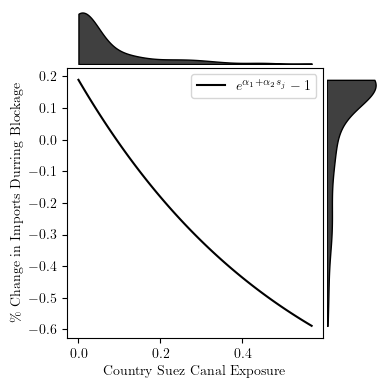

In [170]:
fig, ax = plt.subplots(2, 2, width_ratios=[5, 1], height_ratios=[1, 5], sharex='col', sharey='row')
fig.set_figwidth(PAGE_WIDTH / 2)
fig.set_figheight(PAGE_WIDTH / 2)
ax[0, 0].axis('off') # top left corner (exposure density)
ax[0, 1].axis('off') # top right corner (blank)
ax[1, 1].axis('off') # top right corner (effect density)
ax[1, 0].set_xlabel(f'Country {canal_name.title()} Canal Exposure')
ax[1, 0].set_ylabel(r'\% Change in Imports Durring Blockage')

x = np.linspace(min(earth['v_ratio_'+canal_name]), max(earth['v_ratio_'+canal_name]), 100)
y = np.exp(res_cargo_dummy.coef()['cargo_crash_now'] + x*res_cargo_dummy.coef()['cargo_crash_now:v_ratio_'+canal_name])-1

ax[1, 0].plot(x, y, 'k', label=r'$e^{\alpha_1 + \alpha_2 s_j}-1$') # plot the data

sns.kdeplot( # desity of exposure
    earth['v_ratio_suez'],
    ax=ax[0, 0],
    cut=0,
    color='k',
    multiple="stack"
)

sns.kdeplot( # desity of effect
    y=np.exp(res_cargo_dummy.coef()['cargo_crash_now'] + earth['v_ratio_suez']*res_cargo_dummy.coef()['cargo_crash_now:v_ratio_suez'])-1,
    ax=ax[1, 1],
    cut=0,
    color='k',
    multiple="stack"
)

ax[1, 0].legend()
fig.tight_layout(pad=0.25)
if save: fig.savefig(f'../{save_folder}/graphs/country_{canal_name}_exposure_effect.pdf')

#### Robustness: Quantity Exposure Maasure

/var/folders/7l/ffzd6jqd4k1g060d9whf4v2c0000gn/T/ipykernel_44334/3230640069.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
/var/folders/7l/ffzd6jqd4k1g060d9whf4v2c0000gn/T/ipykernel_44334/3230640069.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in 

###

Estimation:  OLS
Dep. var.: log_mtc, Fixed effects: country_name
Inference:  CRV1
Observations:  3100

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| crash_now              |      0.142 |        0.179 |     0.795 |      0.429 | -0.213 |   0.498 |
| crash_now:q_ratio_suez |     -2.582 |        1.013 |    -2.549 |      0.013 | -4.595 |  -0.570 |
---
RMSE: 2.82   R2: 0.515   R2 Within: 0.002
###

Estimation:  OLS
Dep. var.: log_mtc, Fixed effects: country_name
Inference:  CRV1
Observations:  3100

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| crash_now:q_ratio_suez |     -2.070 |        0.832 |    -2.489 |      0.015 | -3.723 |  -0.417 |
---
RMSE: 2.82   R2: 0.515   R2 Within: 0.001

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           q_ratio_suez   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     1047.
Date:                Fri, 03 May 2024   Prob (F-statistic):           1.77e-63
Time:                        11:24:47   Log-Likelihood:                 259.37
No. Observations:                 130   AIC:                            -514.7
Df Residuals:                     128   BIC:                            -509.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0045      0.003     -1.344      0.181      -0.011       0.002
v_ratio_suez     0.8837      0.027     32.360      0.000       0.830       0.938
==============================================================================
Omnibus:                       35.557   Durbin-Watson:                   2.198
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              329.932
Skew:                           0.500   Prob(JB):                     2.27e-72
Kurtosis:                      10.740   Cond. No.                         9.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

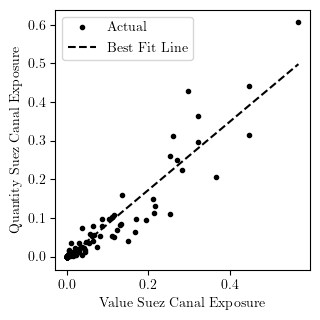

In [171]:
# read files
# Get file
country_imports = pd.read_csv('data/AisData.csv')
earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ports = sn.geodataframe_from_csv('data/Global port supply-chains/Port_statistics/port_locations_value.csv')
ports = ports[['id', 'name', 'iso3', 'geometry', 'lat', 'lon']]
shipping_network = sn.geodataframe_from_csv('data/Global port supply-chains/Maritime_transport/maritime_network_flows.csv')
shipping_through_canal = sn.geodataframe_from_csv(canal_file)
edges = gpd.read_file('data/Global port supply-chains/Network/edges_maritime_corrected.gpkg')
earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# reorganize
tanker_country_imports = country_imports[country_imports['vesselTypeCode'] == 1][['countryareaDesc', 'date', 'mtc']].rename(columns={'mtc': 'tanker_mtc'})
cargo_country_imports = country_imports[country_imports['vesselTypeCode'] == 2][['countryareaDesc', 'date', 'mtc']].rename(columns={'mtc': 'cargo_mtc'})
country_imports = country_imports[country_imports['vesselTypeCode'] == 0][['countryareaDesc', 'date', 'mtc']]
country_imports = country_imports.merge(
    right=tanker_country_imports,
    on=['countryareaDesc', 'date']
).merge(
    right=cargo_country_imports,
    on=['countryareaDesc', 'date']
).rename(columns={
    'countryareaDesc': 'country_name'
})
country_imports['iso_a3'] = cc.convert(country_imports['country_name']) # get iso3 to merge

# canal scores
shipping_network = sn.canal_reliance(shipping_network, shipping_through_canal, canal_name)

# port inflow scores
ports = ports.merge(
        right=shipping_network[['to_id', 'q_sea_flow', 'v_sea_flow', 'q_sea_flow_' + canal_name, 'v_sea_flow_' + canal_name, 'q_ratio_' + canal_name, 'v_ratio_' + canal_name]],
        left_on='id',
        right_on='to_id'
    )

# get routes
ports = sn.fastest_route_from(orgin_node, edges, ports, canal_name)

# weighted average
wm = lambda x: np.average(x, weights=ports.loc[x.index, 'v_sea_flow'])

# merge data for each country
earth = earth.merge(
        right=ports[['iso3', 'q_sea_flow', 'v_sea_flow', 'q_sea_flow_' + canal_name, 'v_sea_flow_' + canal_name, 'dist_from_' + canal_name]].groupby('iso3').agg(
                q_sea_flow=('q_sea_flow', 'sum'),
                v_sea_flow=('v_sea_flow', 'sum'),
                temp1=('q_sea_flow_' + canal_name, 'sum'),
                temp2=('v_sea_flow_' + canal_name, 'sum'),
                temp3=('dist_from_' + canal_name, wm)
            ).reset_index().rename(columns={
                    'temp1': 'q_sea_flow_' + canal_name,
                    'temp2': 'v_sea_flow_' + canal_name,
                    'temp3': 'dist_from_' + canal_name
                }),
        left_on='iso_a3',
        right_on='iso3'
    )
earth['q_ratio_' + canal_name] = earth['q_sea_flow_' + canal_name] / earth['q_sea_flow']
earth['v_ratio_' + canal_name] = earth['v_sea_flow_' + canal_name] / earth['v_sea_flow']

# country distance from canal
earth['time_from_' + canal_name] = earth['dist_from_' + canal_name] // (ship_speed * 24)
earth['tanker_time_from_' + canal_name] = earth['dist_from_' + canal_name] // (tanker_speed * 24)
earth['cargo_time_from_' + canal_name] = earth['dist_from_' + canal_name] // (cargo_speed * 24)

# combine
country_imports = country_imports.merge( # port_id manually checked to work for 100 ports (thank god, this would be awful)
    right=earth,
    on='iso_a3'
)

# lags
country_imports['log_mtc'] = np.log(country_imports['mtc']+1)
country_imports['log_tanker_mtc'] = np.log(country_imports['tanker_mtc']+1)
country_imports['log_cargo_mtc'] = np.log(country_imports['cargo_mtc']+1)

# normalize time
country_imports['ref_date'] = pd.to_datetime(country_imports['date']) - pd.to_timedelta(country_imports['time_from_' + canal_name], 'd')
country_imports['tanker_ref_date'] = pd.to_datetime(country_imports['date']) - pd.to_timedelta(country_imports['tanker_time_from_' + canal_name], 'd')
country_imports['cargo_ref_date'] = pd.to_datetime(country_imports['date']) - pd.to_timedelta(country_imports['cargo_time_from_' + canal_name], 'd')
country_imports['crash_now'] = country_imports['tanker_crash_now'] = country_imports['cargo_crash_now'] = 0
country_imports.loc[(country_imports['ref_date'] >= pd.Timestamp('2021-03-23'))*
                    (country_imports['ref_date'] <= pd.Timestamp('2021-03-29')), 'crash_now'] = 1
country_imports.loc[(country_imports['tanker_ref_date'] >= pd.Timestamp('2021-03-23'))*
                    (country_imports['tanker_ref_date'] <= pd.Timestamp('2021-03-29')), 'tanker_crash_now'] = 1
country_imports.loc[(country_imports['cargo_ref_date'] >= pd.Timestamp('2021-03-23'))*
                    (country_imports['cargo_ref_date'] <= pd.Timestamp('2021-03-29')), 'cargo_crash_now'] = 1

# Regression
res_dummy = pf.feols(
    f'log_mtc ~  crash_now:q_ratio_{canal_name} + crash_now | country_name',
    data=country_imports[(country_imports['ref_date'] >= reg_start.tz_convert(None))*(country_imports['ref_date'] <= reg_end.tz_convert(None))]
)
res_no_dummy = pf.feols(
    f'log_mtc ~  crash_now:q_ratio_{canal_name} | country_name',
    data=country_imports[(country_imports['ref_date'] >= reg_start.tz_convert(None))*(country_imports['ref_date'] <= reg_end.tz_convert(None))]
)
res_tanker_dummy = pf.feols(
    f'log_tanker_mtc ~  tanker_crash_now:q_ratio_{canal_name} + tanker_crash_now | country_name',
    data=country_imports[(country_imports['tanker_ref_date'] >= reg_start.tz_convert(None))*(country_imports['tanker_ref_date'] <= reg_end.tz_convert(None))]
)
res_tanker_no_dummy = pf.feols(
    f'log_tanker_mtc ~  tanker_crash_now:q_ratio_{canal_name} | country_name',
    data=country_imports[(country_imports['tanker_ref_date'] >= reg_start.tz_convert(None))*(country_imports['tanker_ref_date'] <= reg_end.tz_convert(None))]
)
res_cargo_dummy = pf.feols(
    f'log_cargo_mtc ~  cargo_crash_now:q_ratio_{canal_name} + cargo_crash_now | country_name',
    data=country_imports[(country_imports['cargo_ref_date'] >= reg_start.tz_convert(None))*(country_imports['cargo_ref_date'] <= reg_end.tz_convert(None))]
)
res_cargo_no_dummy = pf.feols(
    f'log_cargo_mtc ~  cargo_crash_now:q_ratio_{canal_name} | country_name',
    data=country_imports[(country_imports['cargo_ref_date'] >= reg_start.tz_convert(None))*(country_imports['cargo_ref_date'] <= reg_end.tz_convert(None))]
)
res_dummy.summary()
res_no_dummy.summary()
res_tanker_dummy.summary()
res_tanker_no_dummy.summary()
res_cargo_dummy.summary()
res_cargo_no_dummy.summary()

# value vs quanitty
reg = sm.OLS(earth['q_ratio_' + canal_name], sm.add_constant(earth['v_ratio_' + canal_name])).fit()

fig, ax = plt.subplots()
fig.set_figheight(3)
fig.set_figwidth(3)
ax.set_ylabel('Quantity ' + canal_name.title() + ' Canal Exposure')
ax.set_xlabel('Value ' + canal_name.title() + ' Canal Exposure')

ax.plot(earth['v_ratio_' + canal_name], earth['q_ratio_' + canal_name], 'k.', label='Actual')
ax.plot([min(earth['v_ratio_' + canal_name]), max(earth['v_ratio_' + canal_name])], [min(reg.predict()), max(reg.predict())], 'k--', label='Best Fit Line')

ax.legend()
fig.tight_layout(pad=0)
if save: fig.savefig(f'../{save_folder}/graphs/country_v_vs_q_exposure_{canal_name}.pdf')

reg.summary()

#### Robustness: Dynamic Model

/var/folders/7l/ffzd6jqd4k1g060d9whf4v2c0000gn/T/ipykernel_44334/1684434398.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
/var/folders/7l/ffzd6jqd4k1g060d9whf4v2c0000gn/T/ipykernel_44334/1684434398.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in 

###

Estimation:  OLS
Dep. var.: log_mtc, Fixed effects: country_name
Inference:  CRV1
Observations:  3100

| Coefficient                                |   Estimate |   Std. Error |   t value |   Pr(>|t|) |    2.5% |   97.5% |
|:-------------------------------------------|-----------:|-------------:|----------:|-----------:|--------:|--------:|
| C(time_since_blockage)[T.-21]:v_ratio_suez |     -3.752 |        3.568 |    -1.052 |      0.296 | -10.842 |   3.337 |
| C(time_since_blockage)[T.-20]:v_ratio_suez |      1.355 |        1.865 |     0.727 |      0.469 |  -2.351 |   5.061 |
| C(time_since_blockage)[T.-19]:v_ratio_suez |      2.026 |        1.902 |     1.065 |      0.290 |  -1.753 |   5.806 |
| C(time_since_blockage)[T.-18]:v_ratio_suez |     -1.709 |        2.375 |    -0.720 |      0.474 |  -6.429 |   3.010 |
| C(time_since_blockage)[T.-17]:v_ratio_suez |      0.506 |        2.694 |     0.188 |      0.851 |  -4.846 |   5.859 |
| C(time_since_blockage)[T.-16]:v_ratio_suez |      

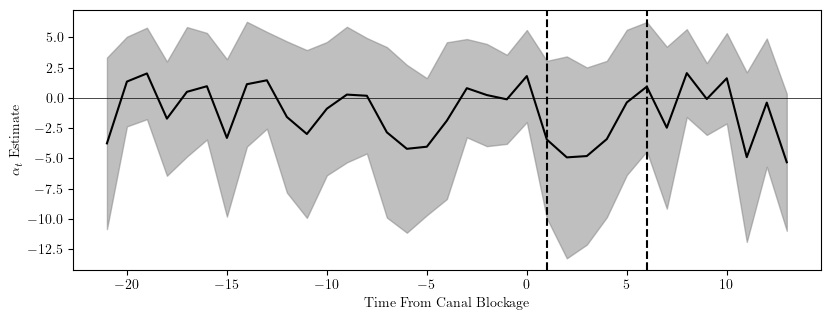

In [172]:
# read files
# Get file
country_imports = pd.read_csv('data/AisData.csv')
earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ports = sn.geodataframe_from_csv('data/Global port supply-chains/Port_statistics/port_locations_value.csv')
ports = ports[['id', 'name', 'iso3', 'geometry', 'lat', 'lon']]
shipping_network = sn.geodataframe_from_csv('data/Global port supply-chains/Maritime_transport/maritime_network_flows.csv')
shipping_through_canal = sn.geodataframe_from_csv(canal_file)
edges = gpd.read_file('data/Global port supply-chains/Network/edges_maritime_corrected.gpkg')
earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# reorganize
tanker_country_imports = country_imports[country_imports['vesselTypeCode'] == 1][['countryareaDesc', 'date', 'mtc']].rename(columns={'mtc': 'tanker_mtc'})
cargo_country_imports = country_imports[country_imports['vesselTypeCode'] == 2][['countryareaDesc', 'date', 'mtc']].rename(columns={'mtc': 'cargo_mtc'})
country_imports = country_imports[country_imports['vesselTypeCode'] == 0][['countryareaDesc', 'date', 'mtc']]
country_imports = country_imports.merge(
    right=tanker_country_imports,
    on=['countryareaDesc', 'date']
).merge(
    right=cargo_country_imports,
    on=['countryareaDesc', 'date']
).rename(columns={
    'countryareaDesc': 'country_name'
})
country_imports['iso_a3'] = cc.convert(country_imports['country_name']) # get iso3 to merge

# canal scores
shipping_network = sn.canal_reliance(shipping_network, shipping_through_canal, canal_name)

# port inflow scores
ports = ports.merge(
        right=shipping_network[['to_id', 'q_sea_flow', 'v_sea_flow', 'q_sea_flow_' + canal_name, 'v_sea_flow_' + canal_name, 'q_ratio_' + canal_name, 'v_ratio_' + canal_name]],
        left_on='id',
        right_on='to_id'
    )

# get routes
ports = sn.fastest_route_from(orgin_node, edges, ports, canal_name)

# weighted average
wm = lambda x: np.average(x, weights=ports.loc[x.index, 'v_sea_flow'])

# merge data for each country
earth = earth.merge(
        right=ports[['iso3', 'q_sea_flow', 'v_sea_flow', 'q_sea_flow_' + canal_name, 'v_sea_flow_' + canal_name, 'dist_from_' + canal_name]].groupby('iso3').agg(
                q_sea_flow=('q_sea_flow', 'sum'),
                v_sea_flow=('v_sea_flow', 'sum'),
                temp1=('q_sea_flow_' + canal_name, 'sum'),
                temp2=('v_sea_flow_' + canal_name, 'sum'),
                temp3=('dist_from_' + canal_name, wm)
            ).reset_index().rename(columns={
                    'temp1': 'q_sea_flow_' + canal_name,
                    'temp2': 'v_sea_flow_' + canal_name,
                    'temp3': 'dist_from_' + canal_name
                }),
        left_on='iso_a3',
        right_on='iso3'
    )
earth['q_ratio_' + canal_name] = earth['q_sea_flow_' + canal_name] / earth['q_sea_flow']
earth['v_ratio_' + canal_name] = earth['v_sea_flow_' + canal_name] / earth['v_sea_flow']

# country distance from canal
earth['time_from_' + canal_name] = earth['dist_from_' + canal_name] // (ship_speed * 24)
earth['tanker_time_from_' + canal_name] = earth['dist_from_' + canal_name] // (tanker_speed * 24)
earth['cargo_time_from_' + canal_name] = earth['dist_from_' + canal_name] // (cargo_speed * 24)

# combine
country_imports = country_imports.merge( # port_id manually checked to work for 100 ports (thank god, this would be awful)
    right=earth,
    on='iso_a3'
)

# lags
country_imports['log_mtc'] = np.log(country_imports['mtc']+1)

# normalize time
country_imports['ref_date'] = pd.to_datetime(country_imports['date']) - pd.to_timedelta(country_imports['time_from_' + canal_name], 'd')
country_imports['time_since_blockage'] = (country_imports['ref_date'] - pd.Timestamp('2021-03-22')).dt.days

# Regression
res_no_dummy = pf.feols(
    f'log_mtc ~  C(time_since_blockage):v_ratio_{canal_name} | country_name',
    data=country_imports[(country_imports['ref_date'] >= reg_start.tz_convert(None))*(country_imports['ref_date'] <= reg_end.tz_convert(None))]
)
res_dummy = pf.feols(
    f'log_mtc ~  C(time_since_blockage):v_ratio_{canal_name} + C(time_since_blockage) | country_name',
    data=country_imports[(country_imports['ref_date'] >= reg_start.tz_convert(None))*(country_imports['ref_date'] <= reg_end.tz_convert(None))]
)
res_no_dummy.summary()
res_dummy.summary()

# setup plot
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(3)
ax.set_xlabel("Time From Canal Blockage")
ax.set_ylabel(r"$\alpha_t$ Estimate")

# plot coefficeints
ax.axvline(1, color='k', linestyle='--')
ax.axvline(6, color='k', linestyle='--')
ax.axhline(0, color='k', linestyle='-', linewidth=0.5)

times = range(-21, 14)
ax.plot(times, res_no_dummy.coef(), 'k-')
ax.fill_between(times,
           res_no_dummy.confint()['0.025%'],
           res_no_dummy.confint()['0.975%'],
           color='gray', alpha=0.5)

# final things
fig.tight_layout(pad=0)
if save: fig.savefig(f'../{save_folder}/graphs/country_' + canal_name +'_dynamic_reg.pdf')

#### Robustness: Speed Choice

/var/folders/7l/ffzd6jqd4k1g060d9whf4v2c0000gn/T/ipykernel_44334/2856050815.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
/var/folders/7l/ffzd6jqd4k1g060d9whf4v2c0000gn/T/ipykernel_44334/2856050815.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in 

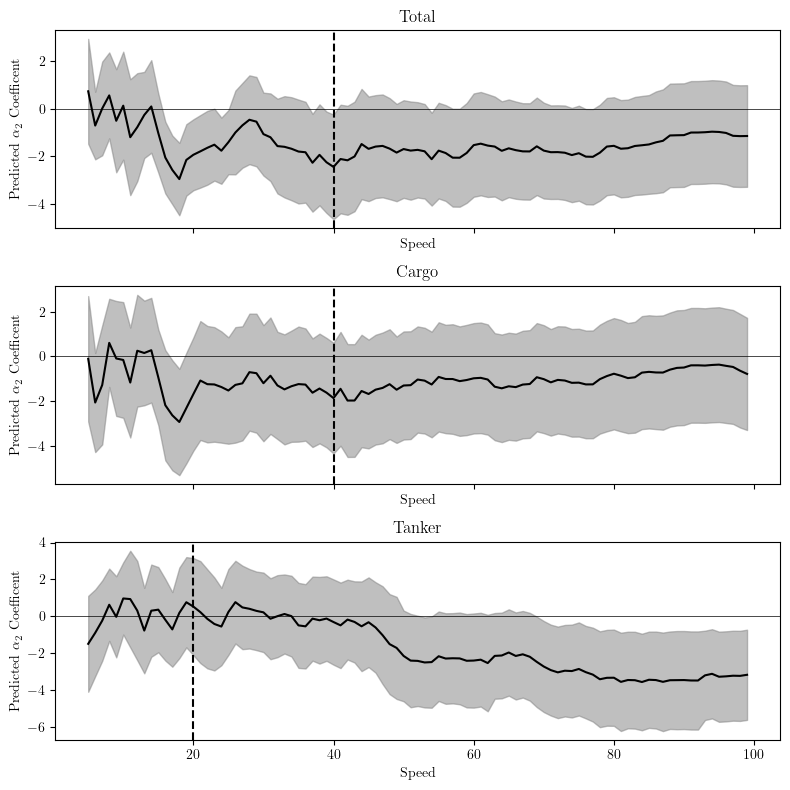

In [182]:
# read files
# Get file
country_imports = pd.read_csv('data/AisData.csv')
earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ports = sn.geodataframe_from_csv('data/Global port supply-chains/Port_statistics/port_locations_value.csv')
ports = ports[['id', 'name', 'iso3', 'geometry', 'lat', 'lon']]
shipping_network = sn.geodataframe_from_csv('data/Global port supply-chains/Maritime_transport/maritime_network_flows.csv')
shipping_through_canal = sn.geodataframe_from_csv(canal_file)
edges = gpd.read_file('data/Global port supply-chains/Network/edges_maritime_corrected.gpkg')
earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# reorganize
tanker_country_imports = country_imports[country_imports['vesselTypeCode'] == 1][['countryareaDesc', 'date', 'mtc']].rename(columns={'mtc': 'tanker_mtc'})
cargo_country_imports = country_imports[country_imports['vesselTypeCode'] == 2][['countryareaDesc', 'date', 'mtc']].rename(columns={'mtc': 'cargo_mtc'})
country_imports = country_imports[country_imports['vesselTypeCode'] == 0][['countryareaDesc', 'date', 'mtc']]
country_imports = country_imports.merge(
    right=tanker_country_imports,
    on=['countryareaDesc', 'date']
).merge(
    right=cargo_country_imports,
    on=['countryareaDesc', 'date']
).rename(columns={
    'countryareaDesc': 'country_name'
})
country_imports['iso_a3'] = cc.convert(country_imports['country_name']) # get iso3 to merge

# canal scores
shipping_network = sn.canal_reliance(shipping_network, shipping_through_canal, canal_name)

# port inflow scores
ports = ports.merge(
        right=shipping_network[['to_id', 'q_sea_flow', 'v_sea_flow', 'q_sea_flow_' + canal_name, 'v_sea_flow_' + canal_name, 'q_ratio_' + canal_name, 'v_ratio_' + canal_name]],
        left_on='id',
        right_on='to_id'
    )

# get routes
ports = sn.fastest_route_from(orgin_node, edges, ports, canal_name)

# weighted average
wm = lambda x: np.average(x, weights=ports.loc[x.index, 'v_sea_flow'])

# merge data for each country
earth = earth.merge(
        right=ports[['iso3', 'q_sea_flow', 'v_sea_flow', 'q_sea_flow_' + canal_name, 'v_sea_flow_' + canal_name, 'dist_from_' + canal_name]].groupby('iso3').agg(
                q_sea_flow=('q_sea_flow', 'sum'),
                v_sea_flow=('v_sea_flow', 'sum'),
                temp1=('q_sea_flow_' + canal_name, 'sum'),
                temp2=('v_sea_flow_' + canal_name, 'sum'),
                temp3=('dist_from_' + canal_name, wm)
            ).reset_index().rename(columns={
                    'temp1': 'q_sea_flow_' + canal_name,
                    'temp2': 'v_sea_flow_' + canal_name,
                    'temp3': 'dist_from_' + canal_name
                }),
        left_on='iso_a3',
        right_on='iso3'
    )
earth['q_ratio_' + canal_name] = earth['q_sea_flow_' + canal_name] / earth['q_sea_flow']
earth['v_ratio_' + canal_name] = earth['v_sea_flow_' + canal_name] / earth['v_sea_flow']

# track results
dummy = []
no_dummy = []
tanker_dummy = []
tanker_no_dummy = []
cargo_dummy = []
cargo_no_dummy = []

perm_country_imports = country_imports.copy()
speeds = range(5, 100)
for speed in range(5,100):
    country_imports = perm_country_imports.copy()

    # country distance from canal
    earth['time_from_' + canal_name] = earth['dist_from_' + canal_name] // (speed * 24)
    earth['tanker_time_from_' + canal_name] = earth['dist_from_' + canal_name] // (speed * 24)
    earth['cargo_time_from_' + canal_name] = earth['dist_from_' + canal_name] // (speed * 24)

    # combine
    country_imports = country_imports.merge( # port_id manually checked to work for 100 ports (thank god, this would be awful)
        right=earth,
        on='iso_a3'
    )

    # lags
    country_imports['log_mtc'] = np.log(country_imports['mtc']+1)
    country_imports['log_tanker_mtc'] = np.log(country_imports['tanker_mtc']+1)
    country_imports['log_cargo_mtc'] = np.log(country_imports['cargo_mtc']+1)

    # normalize time
    country_imports['ref_date'] = pd.to_datetime(country_imports['date']) - pd.to_timedelta(country_imports['time_from_' + canal_name], 'd')
    country_imports['tanker_ref_date'] = pd.to_datetime(country_imports['date']) - pd.to_timedelta(country_imports['tanker_time_from_' + canal_name], 'd')
    country_imports['cargo_ref_date'] = pd.to_datetime(country_imports['date']) - pd.to_timedelta(country_imports['cargo_time_from_' + canal_name], 'd')
    country_imports['crash_now'] = country_imports['tanker_crash_now'] = country_imports['cargo_crash_now'] = 0
    country_imports.loc[(country_imports['ref_date'] >= pd.Timestamp('2021-03-23'))*
                        (country_imports['ref_date'] <= pd.Timestamp('2021-03-29')), 'crash_now'] = 1
    country_imports.loc[(country_imports['tanker_ref_date'] >= pd.Timestamp('2021-03-23'))*
                        (country_imports['tanker_ref_date'] <= pd.Timestamp('2021-03-29')), 'tanker_crash_now'] = 1
    country_imports.loc[(country_imports['cargo_ref_date'] >= pd.Timestamp('2021-03-23'))*
                        (country_imports['cargo_ref_date'] <= pd.Timestamp('2021-03-29')), 'cargo_crash_now'] = 1

    # Regression
    res_dummy = pf.feols(
        f'log_mtc ~  crash_now:v_ratio_{canal_name} + crash_now | country_name',
        data=country_imports[(country_imports['ref_date'] >= reg_start.tz_convert(None))*(country_imports['ref_date'] <= reg_end.tz_convert(None))]
    )
    res_no_dummy = pf.feols(
        f'log_mtc ~  crash_now:v_ratio_{canal_name} | country_name',
        data=country_imports[(country_imports['ref_date'] >= reg_start.tz_convert(None))*(country_imports['ref_date'] <= reg_end.tz_convert(None))]
    )
    res_tanker_dummy = pf.feols(
        f'log_tanker_mtc ~  tanker_crash_now:v_ratio_{canal_name} + crash_now | country_name',
        data=country_imports[(country_imports['tanker_ref_date'] >= reg_start.tz_convert(None))*(country_imports['tanker_ref_date'] <= reg_end.tz_convert(None))]
    )
    res_tanker_no_dummy = pf.feols(
        f'log_tanker_mtc ~  tanker_crash_now:v_ratio_{canal_name} | country_name',
        data=country_imports[(country_imports['tanker_ref_date'] >= reg_start.tz_convert(None))*(country_imports['tanker_ref_date'] <= reg_end.tz_convert(None))]
    )
    res_cargo_dummy = pf.feols(
        f'log_cargo_mtc ~  cargo_crash_now:v_ratio_{canal_name} + crash_now | country_name',
        data=country_imports[(country_imports['cargo_ref_date'] >= reg_start.tz_convert(None))*(country_imports['cargo_ref_date'] <= reg_end.tz_convert(None))]
    )
    res_cargo_no_dummy = pf.feols(
        f'log_cargo_mtc ~  cargo_crash_now:v_ratio_{canal_name} | country_name',
        data=country_imports[(country_imports['cargo_ref_date'] >= reg_start.tz_convert(None))*(country_imports['cargo_ref_date'] <= reg_end.tz_convert(None))]
    )
    dummy.append(res_dummy)
    no_dummy.append(res_no_dummy)
    tanker_dummy.append(res_tanker_dummy)
    tanker_no_dummy.append(res_tanker_no_dummy)
    cargo_dummy.append(res_cargo_dummy)
    cargo_no_dummy.append(res_cargo_no_dummy)

# setup plot
if present:
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()
    ax = [ax1, ax2, ax3]
    fig = [fig1, fig2, fig3]

    for f in fig:
        f.set_figwidth(8)
        f.set_figheight(3)
else:
    fig, ax = plt.subplots(3, sharex=True)
    fig.set_figwidth(8)
    fig.set_figheight(8)


ax[0].set_title('Total')
ax[1].set_title('Cargo')
ax[2].set_title('Tanker')
for i in range(3):
    ax[i].set_xlabel("Speed")
    ax[i].set_ylabel(r"Predicted $\alpha_2$ Coefficent")
    ax[i].axhline(0, color='k', linestyle='-', linewidth=0.5)

# plot overall coefficeints
ax[0].plot(speeds, [d.coef()['crash_now:v_ratio_' + canal_name] for d in dummy], 'k-')
ax[0].fill_between(speeds,
           [d.confint()['0.025%']['crash_now:v_ratio_' + canal_name] for d in dummy],
           [d.confint()['0.975%']['crash_now:v_ratio_' + canal_name] for d in dummy],
           color='gray', alpha=0.5)
ax[0].axvline(40, color='k', linestyle='--')

# plot cargo coefficeints
ax[1].plot(speeds, [d.coef()['cargo_crash_now:v_ratio_' + canal_name] for d in cargo_dummy], 'k-')
ax[1].fill_between(speeds,
           [d.confint()['0.025%']['cargo_crash_now:v_ratio_' + canal_name] for d in cargo_dummy],
           [d.confint()['0.975%']['cargo_crash_now:v_ratio_' + canal_name] for d in cargo_dummy],
           color='gray', alpha=0.5)
ax[1].axvline(40, color='k', linestyle='--')

# plot tanker coefficeints
ax[2].plot(speeds, [d.coef()['tanker_crash_now:v_ratio_' + canal_name] for d in tanker_dummy], 'k-')
ax[2].fill_between(speeds,
           [d.confint()['0.025%']['tanker_crash_now:v_ratio_' + canal_name] for d in tanker_dummy],
           [d.confint()['0.975%']['tanker_crash_now:v_ratio_' + canal_name] for d in tanker_dummy],
           color='gray', alpha=0.5)
ax[2].axvline(20, color='k', linestyle='--')

# final things
if present:
    for f in fig:
        f.tight_layout(pad=0)

    if save:
        fig1.savefig(f'../{save_folder}/graphs/speed_country_' + canal_name +'_reg_est.pdf')
        fig2.savefig(f'../{save_folder}/graphs/speed_country_' + canal_name +'_reg_est_cargo.pdf')
        fig3.savefig(f'../{save_folder}/graphs/speed_country_' + canal_name +'_reg_est_tanker.pdf')

else:
    fig.tight_layout()
    if save: fig.savefig(f'../{save_folder}/graphs/speed_country_' + canal_name +'_reg_est.pdf')

#### Robustness: Time Effects

In [174]:
# read files
# Get file
country_imports = pd.read_csv('data/AisData.csv')
earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ports = sn.geodataframe_from_csv('data/Global port supply-chains/Port_statistics/port_locations_value.csv')
ports = ports[['id', 'name', 'iso3', 'geometry', 'lat', 'lon']]
shipping_network = sn.geodataframe_from_csv('data/Global port supply-chains/Maritime_transport/maritime_network_flows.csv')
shipping_through_canal = sn.geodataframe_from_csv(canal_file)
edges = gpd.read_file('data/Global port supply-chains/Network/edges_maritime_corrected.gpkg')
earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# reorganize
tanker_country_imports = country_imports[country_imports['vesselTypeCode'] == 1][['countryareaDesc', 'date', 'mtc']].rename(columns={'mtc': 'tanker_mtc'})
cargo_country_imports = country_imports[country_imports['vesselTypeCode'] == 2][['countryareaDesc', 'date', 'mtc']].rename(columns={'mtc': 'cargo_mtc'})
country_imports = country_imports[country_imports['vesselTypeCode'] == 0][['countryareaDesc', 'date', 'mtc']]
country_imports = country_imports.merge(
    right=tanker_country_imports,
    on=['countryareaDesc', 'date']
).merge(
    right=cargo_country_imports,
    on=['countryareaDesc', 'date']
).rename(columns={
    'countryareaDesc': 'country_name'
})
country_imports['iso_a3'] = cc.convert(country_imports['country_name']) # get iso3 to merge

# canal scores
shipping_network = sn.canal_reliance(shipping_network, shipping_through_canal, canal_name)

# port inflow scores
ports = ports.merge(
        right=shipping_network[['to_id', 'q_sea_flow', 'v_sea_flow', 'q_sea_flow_' + canal_name, 'v_sea_flow_' + canal_name, 'q_ratio_' + canal_name, 'v_ratio_' + canal_name]],
        left_on='id',
        right_on='to_id'
    )

# get routes
ports = sn.fastest_route_from(orgin_node, edges, ports, canal_name)

# weighted average
wm = lambda x: np.average(x, weights=ports.loc[x.index, 'v_sea_flow'])

# merge data for each country
earth = earth.merge(
        right=ports[['iso3', 'q_sea_flow', 'v_sea_flow', 'q_sea_flow_' + canal_name, 'v_sea_flow_' + canal_name, 'dist_from_' + canal_name]].groupby('iso3').agg(
                q_sea_flow=('q_sea_flow', 'sum'),
                v_sea_flow=('v_sea_flow', 'sum'),
                temp1=('q_sea_flow_' + canal_name, 'sum'),
                temp2=('v_sea_flow_' + canal_name, 'sum'),
                temp3=('dist_from_' + canal_name, wm)
            ).reset_index().rename(columns={
                    'temp1': 'q_sea_flow_' + canal_name,
                    'temp2': 'v_sea_flow_' + canal_name,
                    'temp3': 'dist_from_' + canal_name
                }),
        left_on='iso_a3',
        right_on='iso3'
    )
earth['q_ratio_' + canal_name] = earth['q_sea_flow_' + canal_name] / earth['q_sea_flow']
earth['v_ratio_' + canal_name] = earth['v_sea_flow_' + canal_name] / earth['v_sea_flow']

# country distance from canal
earth['time_from_' + canal_name] = earth['dist_from_' + canal_name] // (ship_speed * 24)
earth['tanker_time_from_' + canal_name] = earth['dist_from_' + canal_name] // (tanker_speed * 24)
earth['cargo_time_from_' + canal_name] = earth['dist_from_' + canal_name] // (cargo_speed * 24)

# combine
country_imports = country_imports.merge( # port_id manually checked to work for 100 ports (thank god, this would be awful)
    right=earth,
    on='iso_a3'
)

# lags
country_imports['log_mtc'] = np.log(country_imports['mtc']+1)
country_imports['log_tanker_mtc'] = np.log(country_imports['tanker_mtc']+1)
country_imports['log_cargo_mtc'] = np.log(country_imports['cargo_mtc']+1)

# normalize time
country_imports['ref_date'] = pd.to_datetime(country_imports['date']) - pd.to_timedelta(country_imports['time_from_' + canal_name], 'd')
country_imports['tanker_ref_date'] = pd.to_datetime(country_imports['date']) - pd.to_timedelta(country_imports['tanker_time_from_' + canal_name], 'd')
country_imports['cargo_ref_date'] = pd.to_datetime(country_imports['date']) - pd.to_timedelta(country_imports['cargo_time_from_' + canal_name], 'd')
country_imports['crash_now'] = country_imports['tanker_crash_now'] = country_imports['cargo_crash_now'] = 0
country_imports.loc[(country_imports['ref_date'] >= pd.Timestamp('2021-03-23'))*
                    (country_imports['ref_date'] <= pd.Timestamp('2021-03-29')), 'crash_now'] = 1
country_imports.loc[(country_imports['tanker_ref_date'] >= pd.Timestamp('2021-03-23'))*
                    (country_imports['tanker_ref_date'] <= pd.Timestamp('2021-03-29')), 'tanker_crash_now'] = 1
country_imports.loc[(country_imports['cargo_ref_date'] >= pd.Timestamp('2021-03-23'))*
                    (country_imports['cargo_ref_date'] <= pd.Timestamp('2021-03-29')), 'cargo_crash_now'] = 1

# Regression
res_date = pf.feols(
    f'log_mtc ~  crash_now:v_ratio_{canal_name} | country_name + date',
    data=country_imports[(country_imports['ref_date'] >= reg_start.tz_convert(None))*(country_imports['ref_date'] <= reg_end.tz_convert(None))]
)
res_ref_date = pf.feols(
    f'log_mtc ~  crash_now:v_ratio_{canal_name} | country_name + ref_date',
    data=country_imports[(country_imports['ref_date'] >= reg_start.tz_convert(None))*(country_imports['ref_date'] <= reg_end.tz_convert(None))]
)
res_date_ref_date = pf.feols(
    f'log_mtc ~  crash_now:v_ratio_{canal_name} | country_name + date + ref_date',
    data=country_imports[(country_imports['ref_date'] >= reg_start.tz_convert(None))*(country_imports['ref_date'] <= reg_end.tz_convert(None))]
)
res_date.summary()
res_ref_date.summary()
res_date_ref_date.summary()

/var/folders/7l/ffzd6jqd4k1g060d9whf4v2c0000gn/T/ipykernel_44334/2760802918.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
/var/folders/7l/ffzd6jqd4k1g060d9whf4v2c0000gn/T/ipykernel_44334/2760802918.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in 

###

Estimation:  OLS
Dep. var.: log_mtc, Fixed effects: country_name+date
Inference:  CRV1
Observations:  3100

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| crash_now:v_ratio_suez |     -2.042 |        0.982 |    -2.081 |      0.040 | -3.992 |  -0.092 |
---
RMSE: 2.794   R2: 0.524   R2 Within: 0.001
###

Estimation:  OLS
Dep. var.: log_mtc, Fixed effects: country_name+ref_date
Inference:  CRV1
Observations:  3100

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| crash_now:v_ratio_suez |     -2.435 |        1.108 |    -2.198 |      0.031 | -4.638 |  -0.233 |
---
RMSE: 2.807   R2: 0.519   R2 Within: 0.002
###

Estimation:  OLS
Dep. var.: log_mtc, Fixed effects: country_name+date+ref_dat

In [179]:
# read files
# Get file
country_imports = pd.read_csv('data/AisData.csv')
earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ports = sn.geodataframe_from_csv('data/Global port supply-chains/Port_statistics/port_locations_value.csv')
ports = ports[['id', 'name', 'iso3', 'geometry', 'lat', 'lon']]
shipping_network = sn.geodataframe_from_csv('data/Global port supply-chains/Maritime_transport/maritime_network_flows.csv')
shipping_through_canal = sn.geodataframe_from_csv(canal_file)
edges = gpd.read_file('data/Global port supply-chains/Network/edges_maritime_corrected.gpkg')
earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# reorganize
tanker_country_imports = country_imports[country_imports['vesselTypeCode'] == 1][['countryareaDesc', 'date', 'mtc']].rename(columns={'mtc': 'tanker_mtc'})
cargo_country_imports = country_imports[country_imports['vesselTypeCode'] == 2][['countryareaDesc', 'date', 'mtc']].rename(columns={'mtc': 'cargo_mtc'})
country_imports = country_imports[country_imports['vesselTypeCode'] == 0][['countryareaDesc', 'date', 'mtc']]
country_imports = country_imports.merge(
    right=tanker_country_imports,
    on=['countryareaDesc', 'date']
).merge(
    right=cargo_country_imports,
    on=['countryareaDesc', 'date']
).rename(columns={
    'countryareaDesc': 'country_name'
})
country_imports['iso_a3'] = cc.convert(country_imports['country_name']) # get iso3 to merge

# canal scores
shipping_network = sn.canal_reliance(shipping_network, shipping_through_canal, canal_name)

# port inflow scores
ports = ports.merge(
        right=shipping_network[['to_id', 'q_sea_flow', 'v_sea_flow', 'q_sea_flow_' + canal_name, 'v_sea_flow_' + canal_name, 'q_ratio_' + canal_name, 'v_ratio_' + canal_name]],
        left_on='id',
        right_on='to_id'
    )

# get routes
ports = sn.fastest_route_from(orgin_node, edges, ports, canal_name)

# weighted average
wm = lambda x: np.average(x, weights=ports.loc[x.index, 'v_sea_flow'])

# merge data for each country
earth = earth.merge(
        right=ports[['iso3', 'q_sea_flow', 'v_sea_flow', 'q_sea_flow_' + canal_name, 'v_sea_flow_' + canal_name, 'dist_from_' + canal_name]].groupby('iso3').agg(
                q_sea_flow=('q_sea_flow', 'sum'),
                v_sea_flow=('v_sea_flow', 'sum'),
                temp1=('q_sea_flow_' + canal_name, 'sum'),
                temp2=('v_sea_flow_' + canal_name, 'sum'),
                temp3=('dist_from_' + canal_name, wm)
            ).reset_index().rename(columns={
                    'temp1': 'q_sea_flow_' + canal_name,
                    'temp2': 'v_sea_flow_' + canal_name,
                    'temp3': 'dist_from_' + canal_name
                }),
        left_on='iso_a3',
        right_on='iso3'
    )
earth['q_ratio_' + canal_name] = earth['q_sea_flow_' + canal_name] / earth['q_sea_flow']
earth['v_ratio_' + canal_name] = earth['v_sea_flow_' + canal_name] / earth['v_sea_flow']

# country distance from canal
earth['time_from_' + canal_name] = earth['dist_from_' + canal_name] // (ship_speed * 24)
earth['tanker_time_from_' + canal_name] = earth['dist_from_' + canal_name] // (tanker_speed * 24)
earth['cargo_time_from_' + canal_name] = earth['dist_from_' + canal_name] // (cargo_speed * 24)

# combine
country_imports = country_imports.merge( # port_id manually checked to work for 100 ports (thank god, this would be awful)
    right=earth,
    on='iso_a3'
)

# lags
country_imports['log_mtc'] = np.log(country_imports['mtc']+1)
country_imports['log_tanker_mtc'] = np.log(country_imports['tanker_mtc']+1)
country_imports['log_cargo_mtc'] = np.log(country_imports['cargo_mtc']+1)

# normalize time
country_imports['ref_date'] = pd.to_datetime(country_imports['date']) - pd.to_timedelta(country_imports['time_from_' + canal_name], 'd')
country_imports['tanker_ref_date'] = pd.to_datetime(country_imports['date']) - pd.to_timedelta(country_imports['tanker_time_from_' + canal_name], 'd')
country_imports['cargo_ref_date'] = pd.to_datetime(country_imports['date']) - pd.to_timedelta(country_imports['cargo_time_from_' + canal_name], 'd')
country_imports['crash_now'] = country_imports['tanker_crash_now'] = country_imports['cargo_crash_now'] = 0
country_imports.loc[(country_imports['ref_date'] >= pd.Timestamp('2021-03-23'))*
                    (country_imports['ref_date'] <= pd.Timestamp('2021-03-29')), 'crash_now'] = 1
country_imports.loc[(country_imports['tanker_ref_date'] >= pd.Timestamp('2021-03-23'))*
                    (country_imports['tanker_ref_date'] <= pd.Timestamp('2021-03-29')), 'tanker_crash_now'] = 1
country_imports.loc[(country_imports['cargo_ref_date'] >= pd.Timestamp('2021-03-23'))*
                    (country_imports['cargo_ref_date'] <= pd.Timestamp('2021-03-29')), 'cargo_crash_now'] = 1
cutoff_1 = 2500 # ports['dist_from_' + canal_name].sort_values().reset_index(drop=True)[len(ports) // 3]
cutoff_2 = 10000 # ports['dist_from_' + canal_name].sort_values().reset_index(drop=True)[2*len(ports) // 3]

# Regression
res_dummy_1 = pf.feols(
    f'log_mtc ~  crash_now:v_ratio_{canal_name} + crash_now | country_name',
    data=country_imports[(country_imports['ref_date'] >= reg_start.tz_convert(None))*(country_imports['ref_date'] <= reg_end.tz_convert(None))*(country_imports['dist_from_' + canal_name] <= cutoff_1)]
)
res_no_dummy_1 = pf.feols(
    f'log_mtc ~  crash_now:v_ratio_{canal_name} | country_name',
    data=country_imports[(country_imports['ref_date'] >= reg_start.tz_convert(None))*(country_imports['ref_date'] <= reg_end.tz_convert(None))*(country_imports['dist_from_' + canal_name] <= cutoff_1)]
)
res_dummy_2 = pf.feols(
    f'log_mtc ~  crash_now:v_ratio_{canal_name} + crash_now | country_name',
    data=country_imports[(country_imports['ref_date'] >= reg_start.tz_convert(None))*(country_imports['ref_date'] <= reg_end.tz_convert(None))*(country_imports['dist_from_' + canal_name] > cutoff_1)*(country_imports['dist_from_' + canal_name] <= cutoff_2)]
)
res_no_dummy_2 = pf.feols(
    f'log_mtc ~  crash_now:v_ratio_{canal_name} | country_name',
    data=country_imports[(country_imports['ref_date'] >= reg_start.tz_convert(None))*(country_imports['ref_date'] <= reg_end.tz_convert(None))*(country_imports['dist_from_' + canal_name] > cutoff_1)*(country_imports['dist_from_' + canal_name] <= cutoff_2)]
)
res_dummy_3 = pf.feols(
    f'log_mtc ~  crash_now:v_ratio_{canal_name} + crash_now | country_name',
    data=country_imports[(country_imports['ref_date'] >= reg_start.tz_convert(None))*(country_imports['ref_date'] <= reg_end.tz_convert(None))*(country_imports['dist_from_' + canal_name] > cutoff_2)]
)
res_no_dummy_3 = pf.feols(
    f'log_mtc ~  crash_now:v_ratio_{canal_name} | country_name',
    data=country_imports[(country_imports['ref_date'] >= reg_start.tz_convert(None))*(country_imports['ref_date'] <= reg_end.tz_convert(None))*(country_imports['dist_from_' + canal_name] > cutoff_2)]
)
res_dummy_1.summary()
res_no_dummy_1.summary()
res_dummy_2.summary()
res_no_dummy_2.summary()
res_dummy_3.summary()
res_no_dummy_3.summary()

/var/folders/7l/ffzd6jqd4k1g060d9whf4v2c0000gn/T/ipykernel_44334/3154960911.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
/var/folders/7l/ffzd6jqd4k1g060d9whf4v2c0000gn/T/ipykernel_44334/3154960911.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  earth = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in regex
Euro Area not found in 

###

Estimation:  OLS
Dep. var.: log_mtc, Fixed effects: country_name
Inference:  CRV1
Observations:  448

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| crash_now              |     -0.964 |        0.969 |    -0.995 |      0.338 | -3.057 |   1.129 |
| crash_now:v_ratio_suez |      0.400 |        2.641 |     0.152 |      0.882 | -5.304 |   6.105 |
---
RMSE: 3.127   R2: 0.354   R2 Within: 0.012
###

Estimation:  OLS
Dep. var.: log_mtc, Fixed effects: country_name
Inference:  CRV1
Observations:  448

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| crash_now:v_ratio_suez |     -2.227 |        1.077 |    -2.069 |      0.059 | -4.553 |   0.099 |
---
RMSE: 3.133   R2: 0.352   R2 Within: 0.008

In [188]:
len(country_imports[(country_imports['ref_date'] >= reg_start.tz_convert(None))*(country_imports['ref_date'] <= reg_end.tz_convert(None))*(country_imports['dist_from_' + canal_name] > cutoff_2)]['country_name'].unique())

36